# Machine Learning Project - Consumer Complaints

## The data

In [4]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

csv_files = 'data/complaints-2020-01-22_08_24/*.csv'
dataset = pd.concat([pd.read_csv(f, header=0, delim_whitespace=False) for f in glob.glob(csv_files)], ignore_index = True)
dataset.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,0,07/23/19,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,926XX,None,Consent provided,Web,07/23/19,Closed with explanation,Yes,NaN,3315279
1,1,07/26/19,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...,Company believes it acted appropriately as aut...,"Ideal Collection Services, Inc.",FL,333XX,None,Consent provided,Web,07/26/19,Closed with explanation,Yes,NaN,3319487
2,2,06/03/19,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...,None,"ONEMAIN FINANCIAL HOLDINGS, LLC.",FL,327XX,None,Consent provided,Web,06/07/19,Closed with explanation,Yes,NaN,3262794
3,3,07/03/19,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...,None,"Diversified Consultants, Inc.",VA,232XX,None,Consent provided,Web,07/03/19,Closed with explanation,Yes,NaN,3295208
4,4,07/14/19,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...,None,"ClearOne Advantage, LLC",PA,191XX,"Older American, Servicemember",Consent provided,Web,07/18/19,Closed with explanation,Yes,NaN,3306130


Initial data cleaning.

In [145]:
import re

# drop columns that aren't going to be used
cleaned_dataset = dataset.drop(['Unnamed: 0', 'Date received', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Company response to consumer', 'Timely response?', 'Date sent to company', 'Consumer disputed?', 'Complaint ID'], axis=1)
# remove useless text parts
cleaned_dataset['Consumer complaint narrative'] = cleaned_dataset['Consumer complaint narrative'].replace(to_replace='xx/xx/\d{4}|XX/XX/\d{4}|\d\d/\d\d/\d{4}|xx/xx/\d{2}|XX/XX/\d{2}|\d\d/\d\d/\d{2}|xx+|XX+|{|}|\$\d+(\.\d+)?', value='', regex=True)
# replace consecutive spaces by only one space
cleaned_dataset['Consumer complaint narrative'] = cleaned_dataset['Consumer complaint narrative'].replace(to_replace='\s\s+', value=' ', regex=True)

In [146]:
cols = ['Product', 'Sub-product', 'Issue', 'Sub-issue']
ids = []
label_to_id = []
id_to_label = []

count = 0
for c in cols:
    one_hot_encoding = pd.get_dummies(cleaned_dataset[c], prefix = c)
    cleaned_dataset = pd.concat([cleaned_dataset, one_hot_encoding], axis = 1)
    
    cleaned_dataset[c + ' id'] = cleaned_dataset[c].factorize()[0]
    ids.append(cleaned_dataset[[c, c + ' id']].drop_duplicates().sort_values(c + ' id'))
    label_to_id.append(dict(ids[count].values))
    id_to_label.append(dict(ids[count][[c + ' id', c]].values))
    count += 1

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gwerrebr/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/gwerrebr/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/gwerrebr/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Data cleaning by removing symbols, short words, stopwords and by stemming words to their dictionary form by using a lemmatizer.

In [2]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

def clean_col(col):
    cleaned_col = []
    for r in range(0,len(col)):
        row = str(col[r])
        row = row.lower()
        row = re.sub('[^a-zA-Z]',' ', row)
        row = re.sub(r'\b\w{1}\b', '', row)

        word_tokens = word_tokenize(row)
        
        row = [w for w in word_tokens if w not in stop_words]
        row = ' '.join(row)
        row = [lemma.lemmatize(w) for w in word_tokenize(str(row).lower())]
        row = ' '.join(row)
        cleaned_col.append(row)
    return cleaned_col

In [149]:
%%time

cleaned_dataset['Consumer complaint narrative'] = clean_col(cleaned_dataset['Consumer complaint narrative'])

CPU times: user 23min 22s, sys: 2.29 s, total: 23min 24s
Wall time: 23min 24s


In [7]:
show_n_rows = 50

pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = show_n_rows

cleaned_dataset['Consumer complaint narrative'].head(show_n_rows)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Train a Doc2Vec model.

In [8]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

X = cleaned_dataset['Consumer complaint narrative']
Y = [[i] for i in range(len(X))]
tagged_data  = [TaggedDocument(X[i], Y[i]) for i in range(len(X))]


model = Doc2Vec(
    vector_size=300, 
    alpha=0.025, 
    min_alpha=0.00025, 
    min_count=2, 
    sample=0.00001, 
#     window=25, 
#     negative=5, 
    dm=1
)

model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)


filename = "doc2vec_model"
model.save(filename)
print("Model Saved (" + filename + ")")

Model Saved (doc2vec_model)


Vectorize the whole dataset with the trained model.

In [9]:
from gensim.models.doc2vec import Doc2Vec

fname = "doc2vec_model"
model = Doc2Vec.load(fname)
X = cleaned_dataset['Consumer complaint narrative']

vectorized_complaints = []
for x in X[:]:
    vectorized_complaints.append(model.infer_vector(list(x)))

Perform PCA on the vectorized dataset for outlier detection.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(vectorized_complaints)
pca_vectorized_complaints = pca.transform(vectorized_complaints)

Perform SVD on the vectorized dataset for outlier detection.

In [11]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
svd_vectorized_complaints = svd.fit_transform(vectorized_complaints)

Function to detect outliers with 4 different algorithms.

In [12]:
import time

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def compute_and_plot_outliers(data, outliers_fraction=0.01):
    anomaly_algorithms = [
        ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
        ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
        ("Isolation Forest", IsolationForest(contamination=outliers_fraction)),
        ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))
    ]

    xx, yy = np.meshgrid(np.linspace(-1, 1, 150), np.linspace(-1, 1, 150))

    y_preds = []
    
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()

        algorithm.fit(data)

        plt.figure(figsize=(10, 10))
        plt.title("Outlier detection with " + name, size=18)

        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(data)
        else:
            y_pred = algorithm.fit(data).predict(data)
        
        y_preds.append(y_pred)

        if name != "Local Outlier Factor":
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        t1 = time.time()

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(data[:, 0], data[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=15, horizontalalignment='right')
        
        plt.show()
    
    return y_preds

Detect outliers both by using PCA and SVD.

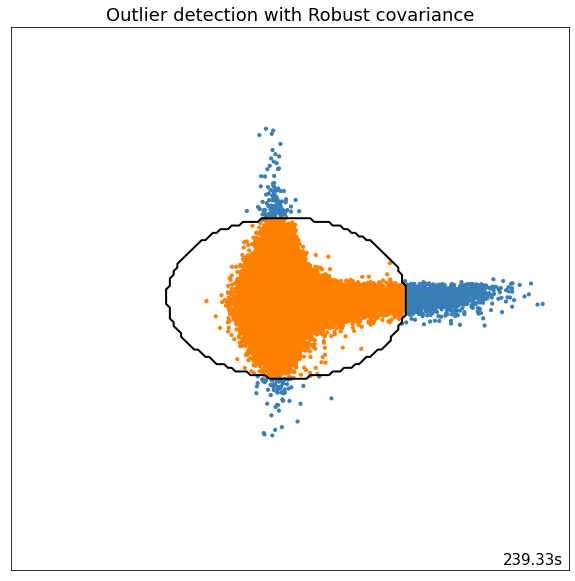

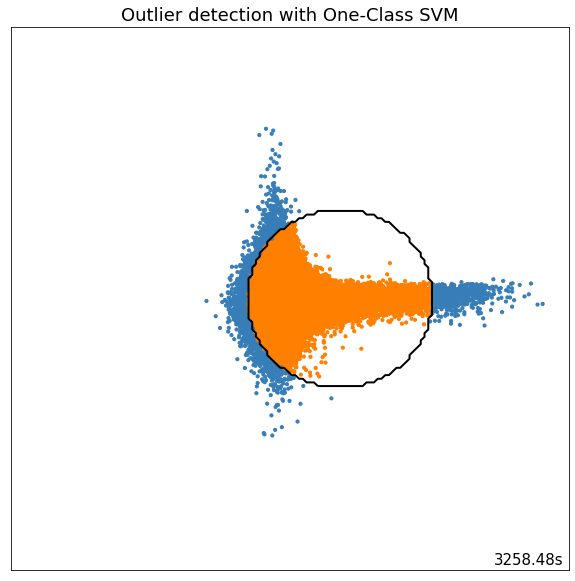

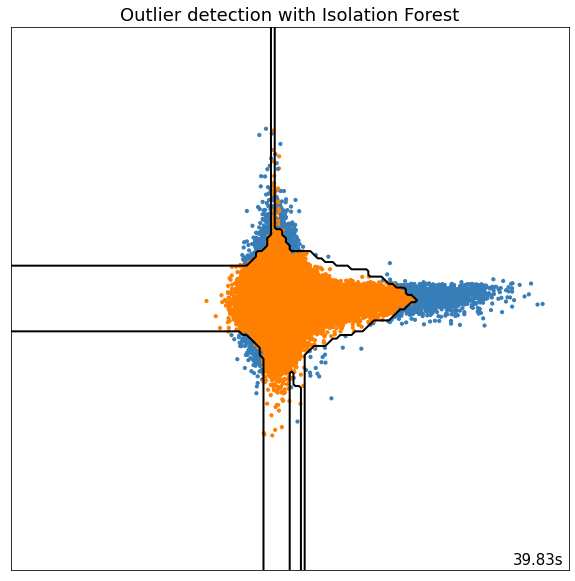

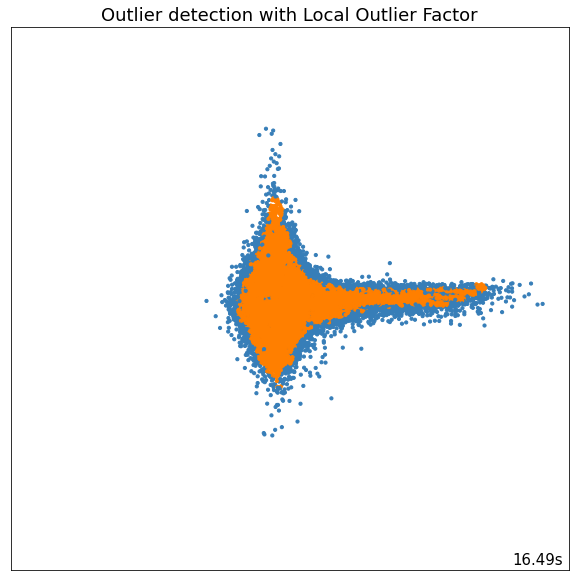

In [13]:
pca_y_preds = compute_and_plot_outliers(pca_vectorized_complaints)

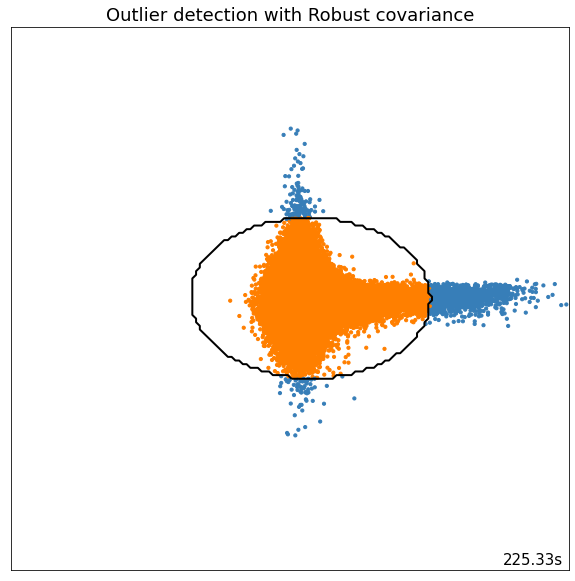

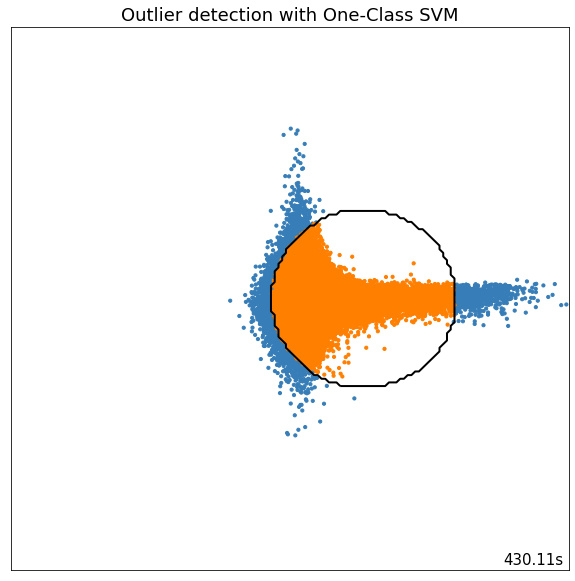

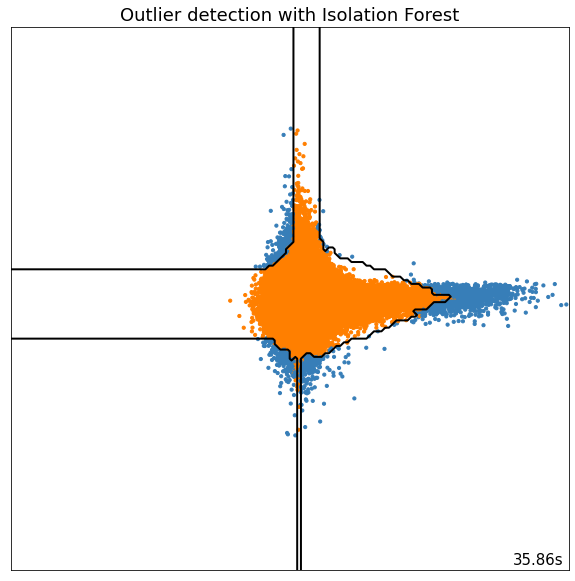

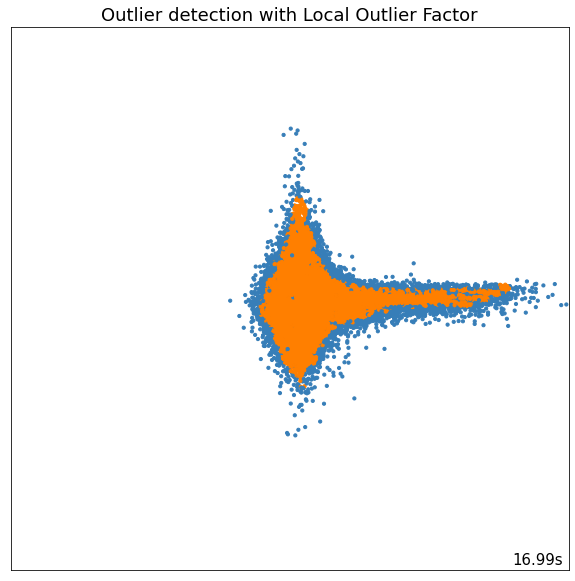

In [14]:
svd_y_preds = compute_and_plot_outliers(svd_vectorized_complaints)

Get all complaint ids that are labelled as outliers.

In [15]:
def get_outlier_ids(y_pred):
    outlier_ids = []

    for id in range(0, len(y_pred)):
        if y_pred[id] == -1:
            outlier_ids.append(id)
    
    return outlier_ids

Get all outliers per algorithm (PCA).

In [16]:
pca_outlier_ids = []
for o in range(0, len(pca_y_preds)):
    outliers = get_outlier_ids(pca_y_preds[o])
    pca_outlier_ids.append(outliers)
    
    print('#outliers:', len(outliers))

#outliers: 4857
#outliers: 4858
#outliers: 4857
#outliers: 4857


Get the intersection of the four outlier detection algorithms when using PCA.

In [20]:
pca_outliers_intersection = list(set(pca_outlier_ids[0]) & set(pca_outlier_ids[1]) & set(pca_outlier_ids[2]) & set(pca_outlier_ids[3]))
print('# of common outliers in all four outlier detection algorithms using PCA:', len(pca_outliers_intersection))

# of common outliers in all four outlier detection algorithms using PCA: 649


In [21]:
print(pca_outliers_intersection)

[456706, 26629, 38917, 419849, 6155, 18451, 319510, 387096, 110616, 374811, 155679, 292896, 315426, 292898, 344101, 88115, 67645, 383045, 333894, 114759, 227400, 51273, 143434, 481373, 278624, 182368, 247904, 278632, 86123, 18541, 153718, 411774, 440448, 333959, 282778, 28827, 139420, 374943, 389286, 338090, 171, 475310, 284846, 403640, 368833, 112835, 329925, 112837, 350407, 41160, 92370, 436435, 28882, 51425, 159972, 155879, 338151, 250088, 190698, 33005, 397549, 153840, 237809, 254194, 286964, 411895, 114936, 430329, 149758, 239870, 207104, 387326, 413950, 139523, 143620, 209157, 473351, 176398, 239889, 338193, 282901, 78106, 477469, 31005, 153891, 375075, 383269, 239910, 420134, 364838, 469291, 272684, 92462, 481582, 180528, 368950, 379195, 356668, 305481, 282958, 346447, 168279, 227676, 117090, 285029, 471400, 287084, 399731, 239994, 24955, 78204, 285050, 194940, 49538, 340354, 242053, 260491, 24974, 133519, 70035, 416154, 371100, 389538, 280999, 274855, 117163, 2477, 442799, 2748

In [26]:
print(dataset['Consumer complaint narrative'][456706])

On XX/XX/XXXX, I purchased 3 Certificate of Deposits, totaling {$800000.00}, from a company fraudulently represented as XXXX XXXX XXXX ( XXXX ), located at XXXX XXXX XXXX, XXXX XXXX, XXXX. My belief is there were errors in the banking processes of XXXX XXXX XXXXXXXX ( XXXX ) and Citibank N.A. ( Citibank ) in their handling of a {$800000.00} wire funds transfer, which was for the purchase of fraudulently represented Certificate of Deposits. My request is for the reimbursement of the {$800000.00} of stolen funds, updating of the all KYC databases with the fraudsters information discovered on this case, and the hopeful improvement of the Financial Institutions wire funds transfer processes to correct conflicting information or improperly utilized  fields on the forms customers sign to authorize the transfers. 

XXXX XXXX XXXXXXXX : There was a fraud prevention process breakdown regarding the critical issue of wiring my funds to an international HIGH-THREAT region. I was presented, and sig

In [27]:
print(dataset['Consumer complaint narrative'][26629])

My mortgage company did not pay my property taxes on time.


In [28]:
print(dataset['Consumer complaint narrative'][38917])

They accepted my deposit but tell me have company do stop payment they are n't closing my account as instructed or giving me my money XXXX


In [29]:
print(dataset['Consumer complaint narrative'][419849])

There were account open for capital one Bank USA NA.XXXX XXXX XXXX UT XXXX onXX/XX/2019 which I didn't open..I had call capital one creditor there don't see anything on file on my name. Could you please check it out for me please thanks


In [30]:
print(dataset['Consumer complaint narrative'][6155])

I am trying to update my address with Capital One to the USPS standard of XXXX XXXX XXXX XXXX, XXXX, WI XXXX, but they claim my new address in in XXXX which is incorrect and I do not want it reported to the credit agencies as such, but they will not correct their system issue


In [31]:
print(dataset['Consumer complaint narrative'][18451])

XXXX breached contract against XXXX XXXX, thus patient not liable for XXXX fees.


In [32]:
print(dataset['Consumer complaint narrative'][319510])

I've contacted Transunion to remove XXXX XXXX XXXX XXXX due to the debt being paid and is currently not a collection. It is still stating as a collection on my credit report.


In [33]:
print(dataset['Consumer complaint narrative'][387096])

I could not get my report online from Equifax and XXXX


In [34]:
print(dataset['Consumer complaint narrative'][110616])

I have inquiries from Equifax that were unauthorized. Equifax do not want to investigate in to the situation for me


In [35]:
print(dataset['Consumer complaint narrative'][374811])

Theyre removing good accounts XXXX and XXXX


___

Get the outliers detected with the robust covariance algorithm using PCA but with the intersection excluded.

In [36]:
pca_outliers_robust_covariance = list(set(pca_outlier_ids[0]) ^ set(pca_outliers_intersection))
len(pca_outliers_robust_covariance)

4208

In [37]:
print(pca_outliers_robust_covariance[:100])
print('...')

[409600, 286729, 425994, 425995, 483338, 409613, 352271, 360468, 385045, 73750, 8215, 221210, 155678, 483361, 24612, 286760, 393257, 417832, 319534, 213039, 106544, 139313, 65586, 352304, 139318, 335927, 57400, 155705, 8258, 376903, 98375, 90185, 344141, 8272, 213073, 8274, 245843, 303187, 41046, 204886, 426075, 368732, 196701, 458844, 393312, 204898, 303209, 385130, 106604, 106608, 344182, 319608, 254073, 303228, 303231, 254082, 134, 442503, 123019, 98445, 147598, 278669, 16528, 221335, 180376, 368791, 73885, 229535, 254114, 32933, 24743, 65708, 123054, 417971, 32948, 98484, 352438, 377013, 377016, 32954, 204986, 327870, 8385, 82114, 245955, 426178, 204999, 417993, 57546, 188619, 450768, 426194, 467157, 57561, 164059, 426204, 49373, 377053, 311520, 123105]
...


In [38]:
print(dataset['Consumer complaint narrative'][409600])

I tried to transfer money that I have had on XXXX for months because I'm in need of it. and when I tried to transfer it said that capital one has blocked me from receiving it.


In [39]:
print(dataset['Consumer complaint narrative'][286729])

XXXX ID : XXXX my account was limited XXXX and funds hasn't been released


In [40]:
print(dataset['Consumer complaint narrative'][425994])

My husband and I printed our credit report, and there was a judgement on the report from 2011. We paid this years ago, after going to the State and getting a print off of Satisfaction of Lien, we then went to the XXXX XXXX XXXX court, who explained we would have to submit a complaint to each reporting bureau.


In [41]:
print(dataset['Consumer complaint narrative'][425995])

Social security Admin. reporting my overpayment as not paid is incorrect. Paid on time.


In [42]:
print(dataset['Consumer complaint narrative'][483338])

it my belief, base discrimintion ( treatment )


___

Get the outliers detected with the one-class SVM algorithm using PCA but with the intersection excluded.

In [43]:
pca_outliers_one_class_svm = list(set(pca_outlier_ids[1]) ^ set(pca_outliers_intersection))
len(pca_outliers_one_class_svm)

4209

In [44]:
print(pca_outliers_one_class_svm[:100])
print('...')

[204803, 245765, 90119, 425994, 409613, 303119, 311312, 393234, 393236, 385045, 253974, 245785, 319513, 180252, 466975, 483361, 434210, 24612, 311337, 319534, 213039, 106544, 376881, 65586, 254004, 81973, 57400, 368697, 352314, 98368, 245825, 8258, 204868, 278597, 24647, 98375, 49225, 90185, 41036, 188493, 385101, 8274, 245843, 303187, 41046, 204886, 262234, 458844, 163934, 155743, 450654, 98402, 180323, 458850, 436384, 385130, 106604, 319597, 385133, 98415, 344182, 49273, 368764, 114813, 82051, 106632, 188557, 237714, 295061, 150, 221337, 458906, 73885, 229535, 311457, 327841, 270500, 90277, 131237, 377002, 65708, 73901, 426159, 377013, 204986, 180411, 327870, 352447, 426174, 82114, 229570, 286914, 204999, 336074, 467157, 418006, 180445, 368864, 82146, 385250]
...


In [46]:
print(dataset['Consumer complaint narrative'][204803])

In XXXX of XXXX, we refinanced our home through XXXX XXXX XXXX in XXXX, VA. In XXXX of that year, XXXX XXXX XXXX sold the loan to XXXX XXXXXXXX XXXX. In XXXX of that year, we re-financed again because we did not like the customer service from XXXX. We re-financed with XXXX which is now XXXX XXXX. In XXXX, Capital One purchased XXXX. In XXXX, we opened a second equity line with XXXX XXXX XXXX in second position. At that time, nothing was found during the title search. When the loan came up for renewal in XXXX, we applied for a renewal. During the title search, an unreleased loan through XXXX XXXX was discovered. I have the HUD Settlement statements from the XXXX loan and the XXXX loan showing that XXXX was paid as well as the letter from XXXX informing us that they had purchased the loan. I called Capital One to ask for a release. The customer service person was able to see the loan number and my name, but had no other information in the system. She refused to send a release. She said s

In [47]:
print(dataset['Consumer complaint narrative'][245765])

EXCUSE THE CATAGORY CHOICE BUT THERES NO OPTION FOR ''CREDIT REPORTING FELONY FRAUD '' AND DEFAMATION OF CHARACTER '' I DONT UNDERSTAND HOW THESE CRIMINALS KEEP GETTING AWAY WITH THIER FRIVOLOUS REPORTS WITHOUT HAVING ANY PROOF OF ANY DEBT,,,,, ,AND NO PROOF OF ANY WRONG DOING,,,,,,,,, NO SWORN AFFIDAVIT THAT HAS BEEN NOTARIZED,,, ,BUT YET XXXX   REMAINS IN BUSINESS OF EXTORTION, WHAT A XXXX PLACE THIS IS,,, CHEXSYSTEMS IS A RICO-EXTORTION RAQUET, THIER PARTNERS IN CRIME HAVE ABSOLUTELY NO EVIDENCE OF A DEBT OWED OR AN INJURED PARTY, I HAVE NEVER RECEIVED A REPORT ON ANYTHING THEYRE REPORTING ON, WHICH IS A MAJOR VIOLATION OF MY RIGHTS AND A VIOLATION OF FRCPA RULES, I AM IN NO WAY OBLIGATED TO GIVE XXXX  MY BIRTHDAY OR SS NUMBER EITHER, CHEXSYSTEMS USES DEFORMATORY INFORMATION ON ME WITHOUT HAVING ABSOLUTELY NO PROOF OF A DEBT OR WRONG-DOING COMMITTED BY ME,, CHEXSYSTEMS COMMITS 2ND DEGREE FELONY BY USING MY PERSONAL INFORMATION WITHOUT MY CONSENT, ALSO RECENTLY I WENT INTO XXXX XXXX 

In [48]:
print(dataset['Consumer complaint narrative'][90119])

CFPB is full of complaints about XXXX. On information and belief, XXXX entered into a settlement agreement for previous bad deeds involving their interaction and conduct with their customers. I have previously attempted to get this matter resolved with XXXX. I recently was contacted by the XXXX CEO Office who indicated they would contact me within two days, that was some weeks ago, and to date I have heard nothing back. I have attached four XXXX 's from XXXX, Cancelling Debt. The issue of a XXXX to the IRS acknowledges XXXX has abandoned all claim to the alleged debt. I previously disputed the debt and provided XXXX verifiable evidence that the debt was based on fraud and not my obligation. I provided XXXX all the law enforcement reports associated with the fraud that I had obtained. XXXX ignored all the evidence and continued to pursue collections. In every case, on each of the four credit cards, XXXX overcharged me for late fees etc. 
XXXX was caught by CFPB and was required to issue

In [49]:
print(dataset['Consumer complaint narrative'][425994])

My husband and I printed our credit report, and there was a judgement on the report from 2011. We paid this years ago, after going to the State and getting a print off of Satisfaction of Lien, we then went to the XXXX XXXX XXXX court, who explained we would have to submit a complaint to each reporting bureau.


In [50]:
print(dataset['Consumer complaint narrative'][409613])

XXXX  showing XXXX, XXXX, exp when i sent hacking and ftc reports


___

Get the outliers detected with the isolation forest algorithm using PCA but with the intersection excluded.

In [51]:
pca_outliers_isolation_forest = list(set(pca_outlier_ids[2]) ^ set(pca_outliers_intersection))
len(pca_outliers_isolation_forest)

4208

In [52]:
print(pca_outliers_isolation_forest[:100])
print('...')

[409600, 245765, 286729, 425994, 409613, 344078, 352271, 360468, 385045, 73750, 8215, 245785, 221210, 180252, 155678, 466975, 483361, 434210, 24612, 311337, 213039, 106544, 139313, 65586, 352304, 81973, 139318, 335927, 57400, 155705, 245825, 8258, 98375, 49225, 90185, 254028, 344141, 8272, 213073, 8274, 245843, 303187, 41046, 204886, 426075, 458844, 196701, 393312, 204898, 180323, 385130, 106604, 106608, 311414, 344182, 319608, 254073, 303228, 134, 98445, 147598, 188557, 16528, 278669, 368791, 180376, 73885, 229535, 32933, 303269, 24743, 327847, 65708, 417971, 98484, 377013, 352438, 377016, 32954, 204986, 327870, 352447, 82114, 245955, 426178, 204999, 417993, 57546, 188619, 450768, 426194, 467157, 57561, 164059, 426204, 49373, 311520, 147682, 319721, 246002]
...


In [53]:
print(dataset['Consumer complaint narrative'][409600])

I tried to transfer money that I have had on XXXX for months because I'm in need of it. and when I tried to transfer it said that capital one has blocked me from receiving it.


In [54]:
print(dataset['Consumer complaint narrative'][245765])

EXCUSE THE CATAGORY CHOICE BUT THERES NO OPTION FOR ''CREDIT REPORTING FELONY FRAUD '' AND DEFAMATION OF CHARACTER '' I DONT UNDERSTAND HOW THESE CRIMINALS KEEP GETTING AWAY WITH THIER FRIVOLOUS REPORTS WITHOUT HAVING ANY PROOF OF ANY DEBT,,,,, ,AND NO PROOF OF ANY WRONG DOING,,,,,,,,, NO SWORN AFFIDAVIT THAT HAS BEEN NOTARIZED,,, ,BUT YET XXXX   REMAINS IN BUSINESS OF EXTORTION, WHAT A XXXX PLACE THIS IS,,, CHEXSYSTEMS IS A RICO-EXTORTION RAQUET, THIER PARTNERS IN CRIME HAVE ABSOLUTELY NO EVIDENCE OF A DEBT OWED OR AN INJURED PARTY, I HAVE NEVER RECEIVED A REPORT ON ANYTHING THEYRE REPORTING ON, WHICH IS A MAJOR VIOLATION OF MY RIGHTS AND A VIOLATION OF FRCPA RULES, I AM IN NO WAY OBLIGATED TO GIVE XXXX  MY BIRTHDAY OR SS NUMBER EITHER, CHEXSYSTEMS USES DEFORMATORY INFORMATION ON ME WITHOUT HAVING ABSOLUTELY NO PROOF OF A DEBT OR WRONG-DOING COMMITTED BY ME,, CHEXSYSTEMS COMMITS 2ND DEGREE FELONY BY USING MY PERSONAL INFORMATION WITHOUT MY CONSENT, ALSO RECENTLY I WENT INTO XXXX XXXX 

In [55]:
print(dataset['Consumer complaint narrative'][286729])

XXXX ID : XXXX my account was limited XXXX and funds hasn't been released


In [56]:
print(dataset['Consumer complaint narrative'][425994])

My husband and I printed our credit report, and there was a judgement on the report from 2011. We paid this years ago, after going to the State and getting a print off of Satisfaction of Lien, we then went to the XXXX XXXX XXXX court, who explained we would have to submit a complaint to each reporting bureau.


In [57]:
print(dataset['Consumer complaint narrative'][409613])

XXXX  showing XXXX, XXXX, exp when i sent hacking and ftc reports


___

Get the outliers detected with the local outlier factor algorithm using PCA but with the intersection excluded.

In [58]:
pca_outliers_local_outlier_factor = list(set(pca_outlier_ids[3]) ^ set(pca_outliers_intersection))
len(pca_outliers_local_outlier_factor)

4208

In [59]:
print(pca_outliers_local_outlier_factor[:100])
print('...')

[212996, 245765, 237576, 155657, 344078, 303119, 147472, 393234, 417811, 73750, 245785, 475161, 106524, 139297, 426021, 73766, 81958, 196647, 311337, 417835, 24621, 319534, 352304, 139313, 245811, 24628, 376891, 204862, 114751, 245825, 450625, 475207, 254028, 376908, 180304, 57428, 65627, 155743, 475232, 41058, 458850, 229482, 417899, 385133, 401517, 98415, 106608, 147569, 344178, 73843, 442484, 229493, 426105, 24699, 385147, 114813, 188542, 196734, 131205, 262281, 98445, 188557, 16528, 180369, 146, 237714, 467091, 295061, 442522, 73884, 311457, 237731, 82084, 32933, 262308, 303269, 327847, 368810, 475307, 73901, 426159, 16567, 32951, 229559, 377015, 90300, 147647, 352447, 196801, 360639, 377027, 426178, 196805, 417989, 131271, 57544, 139465, 245961, 336075, 245969]
...


In [61]:
print(dataset['Consumer complaint narrative'][212996])

The company has placed multiple delinquent notices on my credit causing emotional distress. They also started to garnish my wages and continue to Harass me with phone calls I have documented all phone calls and letters they have sent regarding garnishment and money owed. I have informed the company that if they do not delete the accounts from my credit I will be taking legal action


In [62]:
print(dataset['Consumer complaint narrative'][245765])

EXCUSE THE CATAGORY CHOICE BUT THERES NO OPTION FOR ''CREDIT REPORTING FELONY FRAUD '' AND DEFAMATION OF CHARACTER '' I DONT UNDERSTAND HOW THESE CRIMINALS KEEP GETTING AWAY WITH THIER FRIVOLOUS REPORTS WITHOUT HAVING ANY PROOF OF ANY DEBT,,,,, ,AND NO PROOF OF ANY WRONG DOING,,,,,,,,, NO SWORN AFFIDAVIT THAT HAS BEEN NOTARIZED,,, ,BUT YET XXXX   REMAINS IN BUSINESS OF EXTORTION, WHAT A XXXX PLACE THIS IS,,, CHEXSYSTEMS IS A RICO-EXTORTION RAQUET, THIER PARTNERS IN CRIME HAVE ABSOLUTELY NO EVIDENCE OF A DEBT OWED OR AN INJURED PARTY, I HAVE NEVER RECEIVED A REPORT ON ANYTHING THEYRE REPORTING ON, WHICH IS A MAJOR VIOLATION OF MY RIGHTS AND A VIOLATION OF FRCPA RULES, I AM IN NO WAY OBLIGATED TO GIVE XXXX  MY BIRTHDAY OR SS NUMBER EITHER, CHEXSYSTEMS USES DEFORMATORY INFORMATION ON ME WITHOUT HAVING ABSOLUTELY NO PROOF OF A DEBT OR WRONG-DOING COMMITTED BY ME,, CHEXSYSTEMS COMMITS 2ND DEGREE FELONY BY USING MY PERSONAL INFORMATION WITHOUT MY CONSENT, ALSO RECENTLY I WENT INTO XXXX XXXX 

In [63]:
print(dataset['Consumer complaint narrative'][237576])

I bought a computer from XXXX XXXX but started having problems with them around XX/XX/2015 when XXXX contacted me. I did not know who XXXX was so I called XXXX instead. they stated that they were unable to process my XXXX card. After calling XXXX and XXXX back I was told to now give XXXX the number on the front of the card and NOT the banking and routing number as they previously asked. then everything was fine and they gave me back all late charges they had charged me. They NEVER called me, emailed me or mailed me anything. when I asked them why, they responded that they do not do that?! then a few months later XXXX called me again to say that it was still an issue. I called XXXX, spoke with a supervisor and all was fixed. ALL LATE FEES were given back to me and they were very apologetic. then I found out that they reported these late fees to credit reports. when I called bestbuy again, they agreed they were at fault, apologized again and said that they would fix this with the credit 

In [64]:
print(dataset['Consumer complaint narrative'][155657])

I reached out to you guys on last year regarding some items on my credit that were not mine. There are still a some items that are not mine and needs to be removed. XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX. I have reached out to the FTC and local police regarding this. I am doing this on my own behalf.


In [65]:
print(dataset['Consumer complaint narrative'][344078])

Citibank, N.A., issuer of my Citibank MasterCard, has knowingly permitted a fraudulent charge to remain on my account. XX/XX/XXXX I agreed to pay {$560.00} to XXXX XXXX XXXX XXXX XXXX XXXX Trucking for transportation of an automobile. My credit card, issued by Citibank, was charged that amount XX/XX/XXXX and services were rendered. Sixty days later, XX/XX/XXXX it came to my attention that an authorization of another charge of {$560.00} had posted as a pending transaction to my credit card and immediately called Citibank. Citibank treated this as a disputed transaction and issued a conditional credit of {$560.00} to my account. I did not receive any indication that further action on my part was needed until XX/XX/XXXX when I saw that a reversal of the conditional credit dated XX/XX/XXXX had appeared on my Citibank statement. At that time, I contacted Citibank to inquire about the return of this fraudulent charge and was informed that XXXX had provided a rebuttal to my dispute and that a

___

Get all outliers per algorithm (SVD).

In [66]:
svd_outlier_ids = []
for o in range(0, len(svd_y_preds)):
    outliers = get_outlier_ids(svd_y_preds[o])
    svd_outlier_ids.append(outliers)
    
    print('#outliers:', len(outliers))

#outliers: 4858
#outliers: 4858
#outliers: 4856
#outliers: 4857


In [67]:
svd_outliers_intersection = list(set(svd_outlier_ids[0]) & set(svd_outlier_ids[1]) & set(svd_outlier_ids[2]) & set(svd_outlier_ids[3]))
print('# of common outliers in all four outlier detection algorithms using SVD:', len(svd_outliers_intersection))

# of common outliers in all four outlier detection algorithms using SVD: 670


In [68]:
outliers_intersections_intersection = list(set(pca_outliers_intersection) & set(svd_outliers_intersection))
print('# of common outliers in both PCA and SVD intersections:', len(outliers_intersections_intersection))

# of common outliers in both PCA and SVD intersections: 625


In [69]:
outliers_robust_covariance_intersection = list(set(pca_outlier_ids[0]) ^ set(svd_outlier_ids[0]))
print('# of common outliers with the robust covariance algorithm with SVD that don\'t occur with PCA:', len(outliers_robust_covariance_intersection))

# of common outliers with the robust covariance algorithm with SVD that don't occur with PCA: 5


In [70]:
outliers_one_class_svm_intersection = list(set(pca_outlier_ids[1]) ^ set(svd_outlier_ids[1]))
print('# of common outliers with the one-class svm algorithm with SVD that don\'t occur with PCA:', len(outliers_one_class_svm_intersection))

# of common outliers with the one-class svm algorithm with SVD that don't occur with PCA: 10


In [71]:
outliers_isolation_forest_intersection = list(set(pca_outlier_ids[0]) ^ set(svd_outlier_ids[0]))
print('# of common outliers with the forest isolation algorithm with SVD that don\'t occur with PCA:', len(outliers_isolation_forest_intersection))

# of common outliers with the forest isolation algorithm with SVD that don't occur with PCA: 5


In [72]:
outliers_local_outlier_factor_intersection = list(set(pca_outlier_ids[0]) ^ set(svd_outlier_ids[0]))
print('# of common outliers with the local outlier factor algorithm with SVD that don\'t occur with PCA:', len(outliers_local_outlier_factor_intersection))

# of common outliers with the local outlier factor algorithm with SVD that don't occur with PCA: 5


PCA and SVD don't result in a big difference so the outlier which where found using PCA will be concidered for outlier removal.
___

The robust covariance algorithm seems to give the best result when inspecting the specific outliers found by it.

In [73]:
print('# of complaints in cleaned_dataset:', cleaned_dataset.shape[0])

# of complaints in cleaned_dataset: 485701


In [74]:
dataset_excluding_outliers = dataset.drop(dataset.index[pca_outlier_ids[0]])
print('# of complaints in cleaned_dataset_excluding_outliers:', dataset_excluding_outliers.shape[0])

# of complaints in cleaned_dataset_excluding_outliers: 480844


Use pickle to save the dataset without outliers to a file.

In [75]:
filename = 'dataset_excluding_outliers.csv'
dataset_excluding_outliers.to_csv(filename, index=False)

In [76]:
import pandas as pd

filename = 'dataset_excluding_outliers.csv'
dataset_excluding_outliers = pd.read_csv(filename) 

In [77]:
print('# of complaints in vectorized_complaints:', len(vectorized_complaints))

# of complaints in vectorized_complaints: 485701


In [78]:
vectorized_complaints_cleaned = []

for index in range(0, len(vectorized_complaints)):
    if index not in pca_outlier_ids[0]:
        vectorized_complaints_cleaned.append(vectorized_complaints[index])

print('# of complaints in vectorized_complaints_cleaned:', len(vectorized_complaints_cleaned))

# of complaints in vectorized_complaints_cleaned: 480844


Use pickle to save the cleaned vectorized complaints to a file.

In [79]:
import pickle

filename = 'vectorized_complaints_cleaned.pkl'
data = vectorized_complaints_cleaned
output = open(filename, 'wb')
pickle.dump(data, output)
output.close()

In [1]:
import pickle

filename = 'vectorized_complaints_cleaned.pkl'
pkl_file = open(filename, 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

## Clustering

For the prupose of aquiring a better clustering of the complaints three drastically different clustering methods have been tested. K-means and Hierarchical clustering both have results that weren't useful. The clusters from both techniques were not better than the clusters based on the product label. This for nummerous reasons; the clusters had too much overlap, clusters were not unique enough in terms of frequent keywords, etc.

LDA on the other hand have astonishing results compared to K-means and Hierarchical clustering. LDA has the advantage of taking into account three key components that are important to our clusters, word, context and topic. Another advantage is that LDA clusters in way that it computes a probability in terms of how good it fits into a certain topic/cluster. This also means that most documents fit in multiple topics/clusters with a certain probability for each of those clusters. A good conceptual explanation of LDA can be found here; https://www.youtube.com/watch?v=3mHy4OSyRf0.

In [3]:
import pandas as pd

filename = 'dataset_excluding_outliers.csv'
cleaned_dataset_excluding_outliers = pd.read_csv(filename) 

In [4]:
import re

# drop columns that aren't going to be used
cleaned_dataset_excluding_outliers = cleaned_dataset_excluding_outliers.drop(['Unnamed: 0', 'Date received', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Company response to consumer', 'Timely response?', 'Date sent to company', 'Consumer disputed?', 'Complaint ID'], axis=1)
# remove useless text parts
cleaned_dataset_excluding_outliers['Consumer complaint narrative'] = cleaned_dataset_excluding_outliers['Consumer complaint narrative'].replace(to_replace='xx/xx/\d{4}|XX/XX/\d{4}|\d\d/\d\d/\d{4}|xx/xx/\d{2}|XX/XX/\d{2}|\d\d/\d\d/\d{2}|xx+|XX+|{|}|\$\d+(\.\d+)?', value='', regex=True)
# replace consecutive spaces by only one space
cleaned_dataset_excluding_outliers['Consumer complaint narrative'] = cleaned_dataset_excluding_outliers['Consumer complaint narrative'].replace(to_replace='\s\s+', value=' ', regex=True)

In [5]:
%%time

cleaned_dataset_excluding_outliers['Consumer complaint narrative'] = clean_col(cleaned_dataset_excluding_outliers['Consumer complaint narrative'])

CPU times: user 29min 2s, sys: 3.62 s, total: 29min 6s
Wall time: 29min 6s


The next piece of code will remove some extra stopwords that have been chosen manually because they seem to have unintentionally gotten in the dictionary without being important. We don't concider these words important for clustering because they could be part of any topic.

In [6]:
doc_sample = cleaned_dataset_excluding_outliers['Consumer complaint narrative']
processed_docs = doc_sample.tolist()

extra_stopwords = [
    'told', 'still', 'one', 'said', 'asked', 'sent', 'call', 'amount', 'received', 'would', 
    'could', 'day', 'since', 'never', 'also', 'time', 'back', 'year', 'get', 'even', 
    'paid', 'month', 'pay', 'money', 'bank', 'however', 'made', 'due', 'email', 'stated', 
    'name', 'date', 'want', 'need', 'first', 'know'
]

processed_docs = map(lambda x: x.split(), processed_docs)
processed_docs = map(lambda x: list(filter(lambda y: y not in extra_stopwords, x)) , processed_docs)

In [7]:
processed_docs = list(processed_docs)

The next step is to compute frequent bigrams from the documents.

In [8]:
import gensim

bigram = gensim.models.Phrases(processed_docs, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [9]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [10]:
processed_docs_bigrams = make_bigrams(processed_docs)

LDA uses a dictionary of important words and a corpus which is a bag of words vector representation of the documents. No words that occur in less than 100 documents will be in the dictionary as well as no words that appear in more than 40% of the documents.

In [11]:
import gensim

dictionary = gensim.corpora.Dictionary(processed_docs_bigrams)
dictionary.filter_extremes(no_below=100, no_above=0.4, keep_n=10000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs_bigrams]

The composed dictionary consists of the below mentioned amount of words/bigrams.

In [12]:
print(len(dictionary))

7841


This method is easy to use to compute the Coherence value for a specific k (#topics), a (alpha) and b (eta) combination.

In [28]:
from gensim.models import CoherenceModel

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=1000,
                                           passes=2,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

The following code is a way to do hyperparameter tweaking to find optimal parameters. This is based on the following blog post on validating LDA topics; https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0.

In [29]:
import numpy as np
from tqdm.notebook import trange, tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 6
max_topics = 21
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(bow_corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               bow_corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

In [620]:
import pandas as pd

filename = 'lda_tuning_results.csv'
lda_tuning_results = pd.read_csv(filename) 

The next step is to compute the mean Coherence value over each topic.

In [639]:
df_mean = lda_tuning_results.groupby(['Topics']).mean().reset_index()

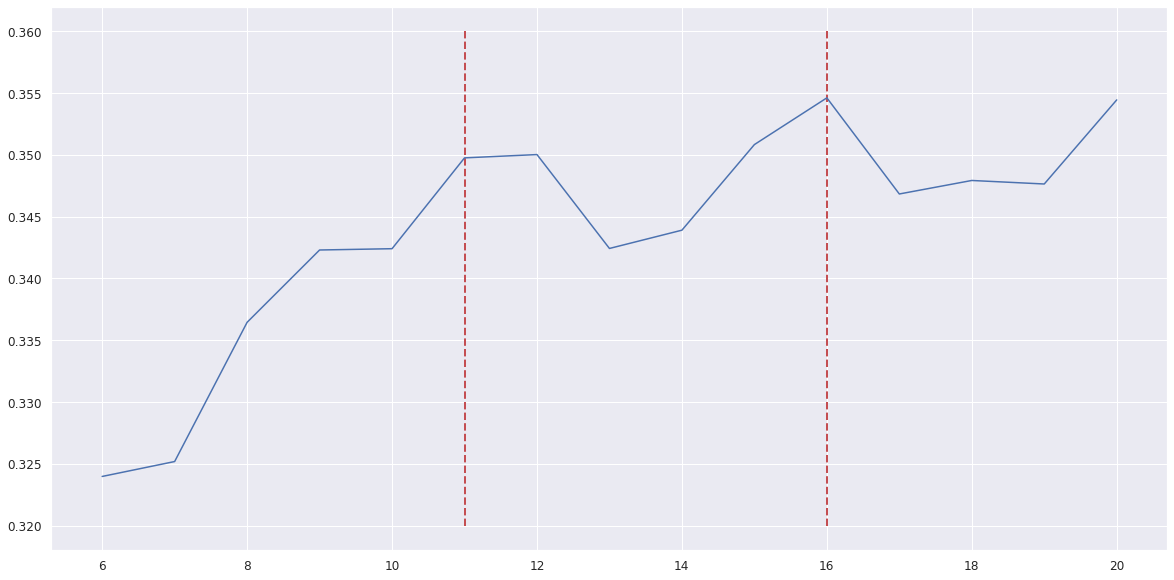

In [640]:
import matplotlib.pyplot as plt
import numpy as np

x = df_mean['Topics']
y = df_mean['Coherence']

fig, ax = plt.subplots()
ax.plot(x, y)
ax.vlines(x=11, ymin=0.32, ymax=0.36, linewidth=2, linestyles='dashed', color='r')
ax.vlines(x=16, ymin=0.32, ymax=0.36, linewidth=2, linestyles='dashed', color='r')

plt.show()

The graph clearly shows two peaks/maxima at 11 and 16 followd by a plateau or decrease. These two values could be suitable as number of topics.

In [642]:
df_std = lda_tuning_results.groupby('Topics').std().reset_index()

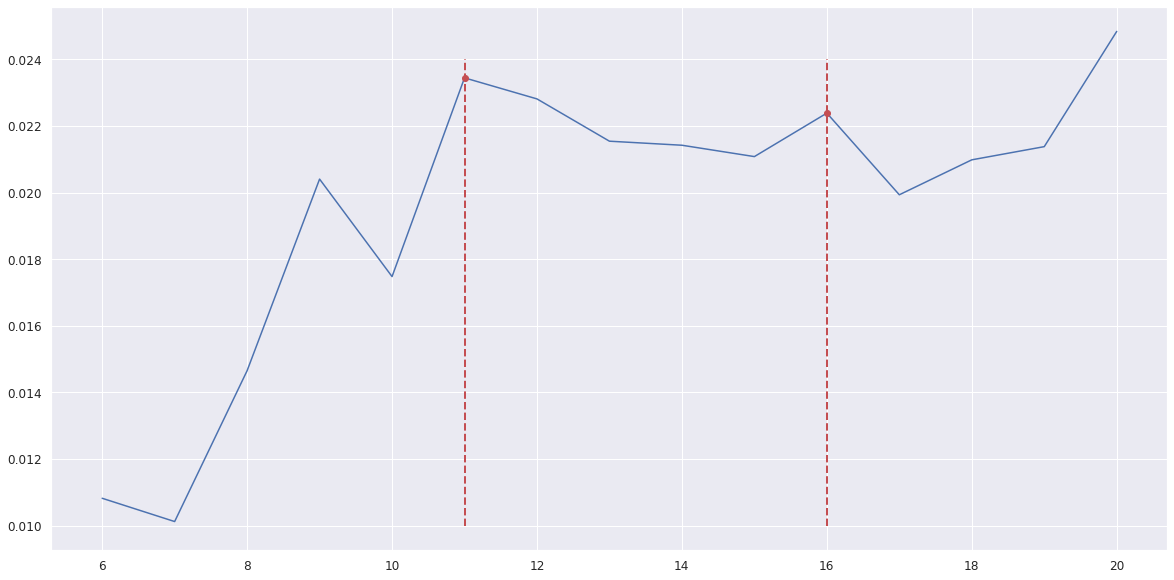

In [643]:
import matplotlib.pyplot as plt
import numpy as np

x = df_std['Topics']
y = df_std['Coherence']

fig, ax = plt.subplots()
ax.plot(x, y)
ax.vlines(x=11, ymin=0.010, ymax=0.024, linewidth=2, linestyles='dashed', color='r')
ax.vlines(x=16, ymin=0.010, ymax=0.024, linewidth=2, linestyles='dashed', color='r')
plt.plot(11, 0.023445, 'ro')
plt.plot(16, 0.022387, 'ro')

plt.show()

The documents will be clustered in 11 topics and with the alpha and beta value that has the maximum Coherence value.

In [644]:
lda_tuning_results.loc[lda_tuning_results['Topics'] == 11].sort_values(by='Coherence', ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
150,100% Corpus,11,0.01,0.01,0.373017
152,100% Corpus,11,0.01,0.61,0.373017
154,100% Corpus,11,0.01,symmetric,0.371331
151,100% Corpus,11,0.01,0.31,0.371331
171,100% Corpus,11,symmetric,0.31,0.369146
170,100% Corpus,11,symmetric,0.01,0.368368
172,100% Corpus,11,symmetric,0.61,0.368368
174,100% Corpus,11,symmetric,symmetric,0.367022
173,100% Corpus,11,symmetric,0.9099999999999999,0.367022
153,100% Corpus,11,0.01,0.9099999999999999,0.365293


The actual model will be trained with 11 topics and the tested parameters as explained above.

In [13]:
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus, id2word=dictionary, num_topics=11, random_state=100, chunksize=1000, passes=2, alpha=0.01, eta=0.01, per_word_topics=True)

In [14]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=16, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.026*"consumer" + 0.018*"information" + 0.015*"report" + 0.009*"agency" + 0.008*"payment" + 0.007*"phone" + 0.007*"identity" + 0.007*"number" + 0.007*"reporting" + 0.006*"theft"

1: 0.013*"loan" + 0.008*"well" + 0.008*"mortgage" + 0.008*"document" + 0.007*"information" + 0.007*"sale" + 0.006*"report" + 0.006*"payment" + 0.006*"property" + 0.006*"company"

2: 0.033*"report" + 0.017*"inquiry" + 0.015*"company" + 0.010*"information" + 0.010*"reporting" + 0.009*"letter" + 0.009*"collection" + 0.008*"debt" + 0.008*"agency" + 0.008*"loan"

3: 0.013*"card" + 0.010*"check" + 0.009*"company" + 0.009*"payment" + 0.007*"mortgage" + 0.007*"information" + 0.006*"balance" + 0.005*"interest" + 0.005*"service" + 0.005*"complaint"

4: 0.015*"loan" + 0.013*"report" + 0.011*"debt" + 0.010*"information" + 0.010*"company" + 0.010*"payment" + 0.007*"address" + 0.007*"reporting" + 0.006*"mortgage" + 0.006*"collection"

5: 0.031*"payment" + 0.021*"loan" + 0.011*"report" + 0.010*"company" + 0.009*"mortgage

The next pieces of code is a test to demonstrate that gensim is capable of classifying in which topic(s) an unseen document fits.

In [651]:
bow = lda_model.id2word.doc2bow('I want a loan for a house.'.split())
doc_topics, word_topics, phi_values = lda_model.get_document_topics(bow, per_word_topics=True)
doc_topics

[(5, 0.90990937)]

In [664]:
bow = lda_model.id2word.doc2bow('My social security number has been stolen and used to do illegal activities.'.split())
doc_topics, word_topics, phi_values = lda_model.get_document_topics(bow, per_word_topics=True)
doc_topics

[(0, 0.9836292)]

In [669]:
bow = lda_model.id2word.doc2bow("I have some late fees on my account which I don't want to comply too because it is not my fault that the bank hasn't been able to inform me about them.".split())
doc_topics, word_topics, phi_values = lda_model.get_document_topics(bow, per_word_topics=True)
doc_topics

[(6, 0.9804221)]

In [670]:
bow = lda_model.id2word.doc2bow("My car loan has been declined because I have outstandind debt on my credit card.".split())
doc_topics, word_topics, phi_values = lda_model.get_document_topics(bow, per_word_topics=True)
doc_topics

[(5, 0.54880595), (7, 0.42929292)]

Acquire the topics for all documents.

In [15]:
get_document_topics = lda_model.get_document_topics(bow_corpus[:])

In [332]:
get_document_topics[0]

[(1, 0.59584), (14, 0.04473914), (15, 0.35615566)]

In [16]:
topics = [lda_model[bow_corpus[i]] for i in range(len(cleaned_dataset_excluding_outliers['Consumer complaint narrative'][:]))]

In [17]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [18]:
document_topic = pd.concat([topics_document_to_dataframe(topics_document, num_topics=11) for topics_document in get_document_topics]).reset_index(drop=True).fillna(0)

The next step is to append the topics to the dataset and save to a csv file.

In [19]:
import pandas as pd

filename = 'dataset_excluding_outliers.csv'
dataset_excluding_outliers = pd.read_csv(filename) 

In [674]:
dataset_excluding_outliers['LDA clusters'] = document_topic.idxmax(axis=1)

In [678]:
dataset_excluding_outliers.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,LDA clusters
0,250000,02/17/17,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,"My husband XXXX XXXX passed away on XXXX/XXXX/XXXX. As you can imagine, I was devastated. We had been married for almost 50 years. He was the father of my children, my business partner and my partner in life. \r\n\r\nMy XXXX for the first several months after XXXX passed away. Everyone kept asking me thousands of questions about our finances, our house, our vehicles, life insurance, etc., but I had no clue how to answer. XXXX had always handled our finances. I eventually figured it all out, ...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,WELLS FARGO & COMPANY,TX,750XX,Older American,Consent provided,Web,02/17/17,Closed with explanation,Yes,No,2350810,1
1,250001,03/31/17,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,"Extortion excess escrow ; with threatened Foreclosure for amounts not due ; attachments define the case with proofs ; opposing counsel states the Stipulated Injunctive order CASE XXXX Document XXXX Filed XX/XX/2015 as brought by FTC and CFPB are not enforceable between customers and Ditech Financial LLC , therefore they did no wrong that can be enforced, or the gist similar thereof ; Phone records and specific calls can be identified with key information, but implications are that the record...",Company believes it acted appropriately as authorized by contract or law,Ditech Financial LLC,MI,48072,None,Consent provided,Web,03/31/17,Closed with explanation,Yes,Yes,2413884,1
2,250002,04/07/17,Debt collection,"Other (i.e. phone, health club, etc.)",Improper contact or sharing of info,Talked to a third party about my debt,I do not have a contract with Diversified Consultants. There is no right to substitute someone or some entity that was not on an original contract. It is not allowed. They are reporting on all XXXX of my credit reports and they need to be removed.,None,"Diversified Consultants, Inc.",MO,631XX,None,Consent provided,Web,04/07/17,Closed with explanation,Yes,No,2424349,10
3,250003,03/24/17,Consumer Loan,Title loan,Payment to acct not credited,None,"A 20 year loan at .0875 simple interest, in XX/XX/XXXX and ongoing, we have made {$17000.00} in principal only payments, as allowed by our original contract ( XX/XX/XXXX ) and interest has been taken out of those payments. There are other anomalies in the account history, that are different from the actuarial table. We have not been given an explanation that is much more than making the numbers say what they want. We have been trying to pay this off since XX/XX/XXXX in person at PNC Bank XXX...",None,PNC Bank N.A.,FL,327XX,None,Consent provided,Web,03/24/17,Closed with explanation,Yes,No,2402336,3
4,250004,08/05/15,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,"I continue to get calls from this company, I believe it is High Point Asset @ XXXX. They are trying to reach XXXX XXXX at my cell number. I have spoken to them several times now, explained that this is not his number, explained that I have had this number for at least 15 years and request that they stop calling. Despite assurance otherwise, they continue to call XXXX at my number.",None,High Point Asset Inc,DE,199XX,Older American,Consent provided,Web,09/21/15,Closed with explanation,No,No,1503579,7


In [679]:
filename = 'dataset_new_clusters.csv'
dataset_excluding_outliers.to_csv(filename, index=False)

In [20]:
import pandas as pd

filename = 'dataset_new_clusters.csv'
dataset_excluding_outliers = pd.read_csv(filename) 

The next step is to compute the heatmap which shows in which topics all documents fit with their probability.

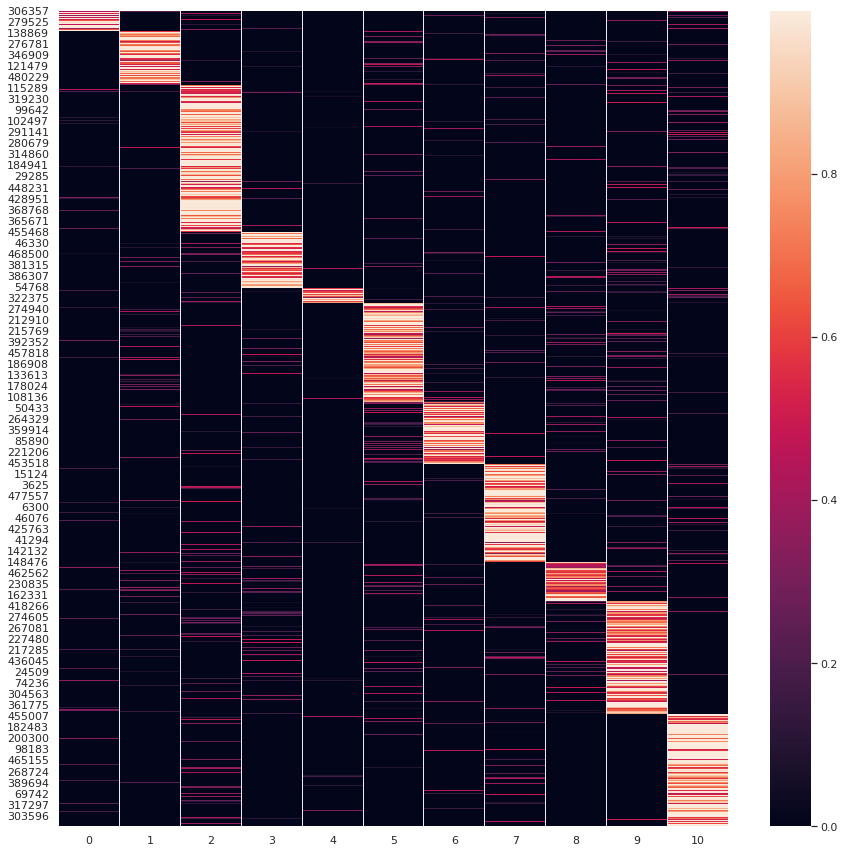

In [544]:
%matplotlib inline
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

The next barplot shows the distribution of the documents over all topics. There is still inbalace between clusters as there was with the product labels but it's less.

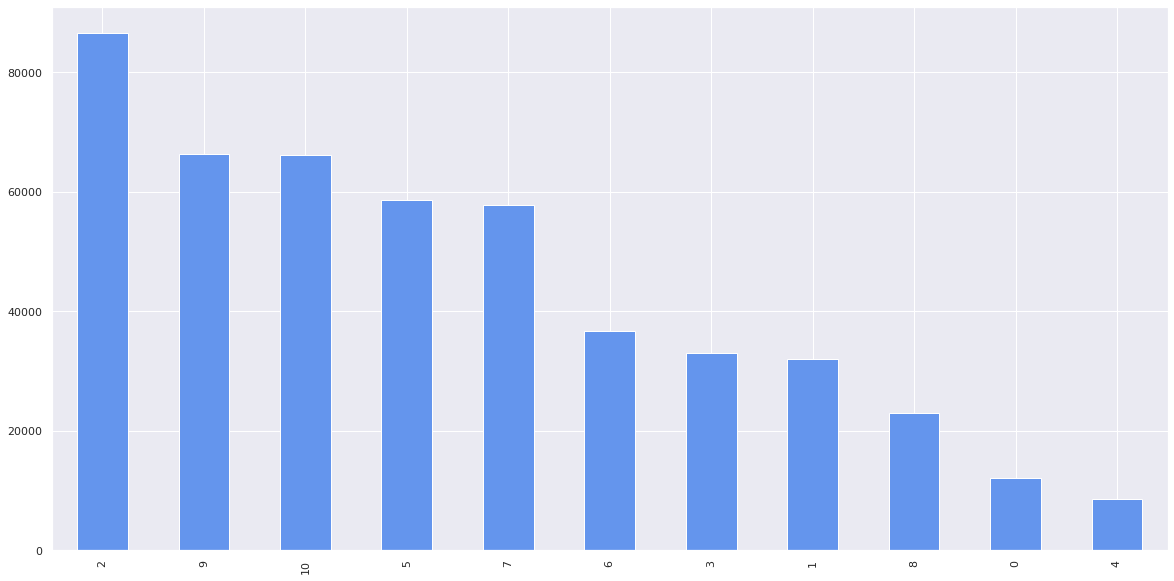

In [605]:
sns.set(rc={'figure.figsize':(20,10)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='cornflowerblue')

The following is a graph which shows the word frequency per topic.

In [546]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=bow_corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

Get the dominant topics, keywords and the contribution percentage.

In [21]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    # get the main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the Dominant topic, perc. contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # add the original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=dataset_excluding_outliers['Consumer complaint narrative'][:])

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9996,"loan, well, mortgage, document, information, s...",My husband XXXX XXXX passed away on XXXX/XXXX/...
1,1,0.0,0.5337,"consumer, information, report, agency, payment...",Extortion excess escrow ; with threatened Fore...
2,2,10.0,0.7255,"information, report, debt, reporting, letter, ...",I do not have a contract with Diversified Cons...
3,3,3.0,0.7186,"card, check, company, payment, mortgage, infor...","A 20 year loan at .0875 simple interest, in XX..."
4,4,7.0,0.9960,"debt, payment, information, collection, number...","I continue to get calls from this company, I b..."
5,5,9.0,0.7075,"card, payment, called, loan, fee, company, cha...",XXXX card issued me a credit line through come...
6,6,7.0,0.6859,"debt, payment, information, collection, number...",Jeffcapsys shows a collection debt on my repor...
7,7,10.0,0.7348,"information, report, debt, reporting, letter, ...",After reviewing my credit profile on XX/XX/XXX...
8,8,10.0,0.9974,"information, report, debt, reporting, letter, ...",From the reporting company stating that no fur...
9,9,1.0,0.9995,"loan, well, mortgage, document, information, s...",To whom this may concern. My name is XXXX. I l...


The next table shows the most representative documents for each topic based on the contribution percentage.

In [22]:
pd.options.display.max_colwidth = 1000

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9998,"consumer, information, report, agency, payment, phone, identity, number, reporting, theft","XXXX XXXX is now a collection account on my report. All 3 bureaus removed this due to identity theft and all 3 put them back on without notifying me. Please see my new ID theft report and remove these items within the 4 days as the law states.\r\n\r\nI would like to request the suppression of the following items from my credit report, which are the result of my falling victim to identity theft. This information does not relate to [ transactions that I have made/accounts that I have opened ], as the attached supporting documentation can attest. As such, it should be blocked from appearing on my credit report pursuant to section 605B of the Fair Credit Reporting Act. \r\nXXXX XXXX-SEE PREVIOUS ID Theft REPort XXXX XXXX XXXX-SEE PREVIOUS ID THEFT REPORT XXXX XXXX ( auto loan ) XXXX XXXX Funding Supporting documents are enclosed with this letter. Please let me know if any additional information is needed. Furthermore, when you accept this request, please send the notifications required..."
1,1.0,0.9999,"loan, well, mortgage, document, information, sale, report, payment, property, company","IN THE CIRCUIT COURT OF THE EIGHTEENTH JUDICIAL CIRCUIT IN AND FOR XXXX COUNTY, FLORIDA CIVIL DIVISION Case No. XXXX XXXX XXXX, XXXX Plaintiff, Loan No. XXXX v. \r\n\r\nXXXX XXXX XXXX, XXXX A/K/A/ XXXX XXXX XXXX \r\nXXXX ; XXXX XXXX XXXX ; UNKNOWN SPOUSE OF XXXX XXXX XXXX, XXXX A/K/A XXXX XXXX XXXX \r\nXXXX ; UNKNOWN SPOUSE OF XXXX XXXX \r\nXXXX ; UNKNOWN TENANT # 1 ; UNKNOWN TENANT # 2 ; ALL OTHER UNKNOWN PARTIES CLAIMING INTERESTS BY, THROUGH, UNDER, AND AGAINST A NAMED DEFENDANT ( S ) WHO ARE NOT KNOWN TO BE DEAD OR ALIVE, WHETHER SAME UNKNOWN PARTIES MAY CLAIM AN INTEREST AS SPOUSES, HEIRS, DEVISEES, GRANTEES, OR OTHER CLAIMAINTS, Defendants, COMPLAINT TO XXXX XXXX Requesting Time to complete Quiet Title procedure enforcement Presently the resolution department at XXXX XXXX is not honoring Article 12 of the Mortgage signed by XXXX XXXX XXXX and XXXX XXXX XXXX on XX/XX/XXXX : Loan No. XXXX ; XXXX ( XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX ). This problem has been continual f..."
2,2.0,0.9998,"report, inquiry, company, information, reporting, letter, collection, debt, agency, loan",These accounts are paid in full. \r\n\r\nXXXX/XXXX Last reported : XX/XX/XXXX {$300.00} XXXX XXXX XXXX Last reported : XX/XX/XXXX {$31000.00} XXXX XXXX XXXX XXXX Last reported : XX/XX/XXXX {$3000.00} The account below is not mines and I have disputed once before.\r\n\r\nXXXX XXXX XXXX Closed : XX/XX/XXXX {$1400.00} XXXX XXXX XXXX Last reported : XX/XX/XXXX {$5900.00} The inquiries below are not authorized by me.\r\n\r\nXXXX iquires : XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX XXXX Inquiry from XX/XX/XXXX Automotive XXXX ...
3,3.0,0.9999,"card, check, company, payment, mortgage, information, balance, interest, service, complaint",Paypal had ny account broken into and my account was Compromise! So they shut my account down and kept my money.! What a scam fraud Company!!!Pl\r\n\r\nDate\r\nTypeNamePaymentGrossFeeNetBalanceActions\r\nFirst 30 transactions\r\n\r\nXX/XX/XXXX\r\nTransfer to Bank Account\r\n\r\n Completed\r\n\r\n-$XXXX USD$XXXX USD-$XXXX USD$XXXX USD\r\nArchive\r\n\r\nXX/XX/XXXX\r\nTransfer from PayPal\r\n\r\n Completed\r\n\r\n$XXXX USD$XXXX USD$XXXX USD$XXXX USD\r\nArchive\r\n\r\nXX/XX/XXXX\r\nTransfer from PayPal\r\n\r\n Completed\r\n\r\

The following graph shows the distribution of important words (dictionary) over all documents and a count of how many documents have that many important words.

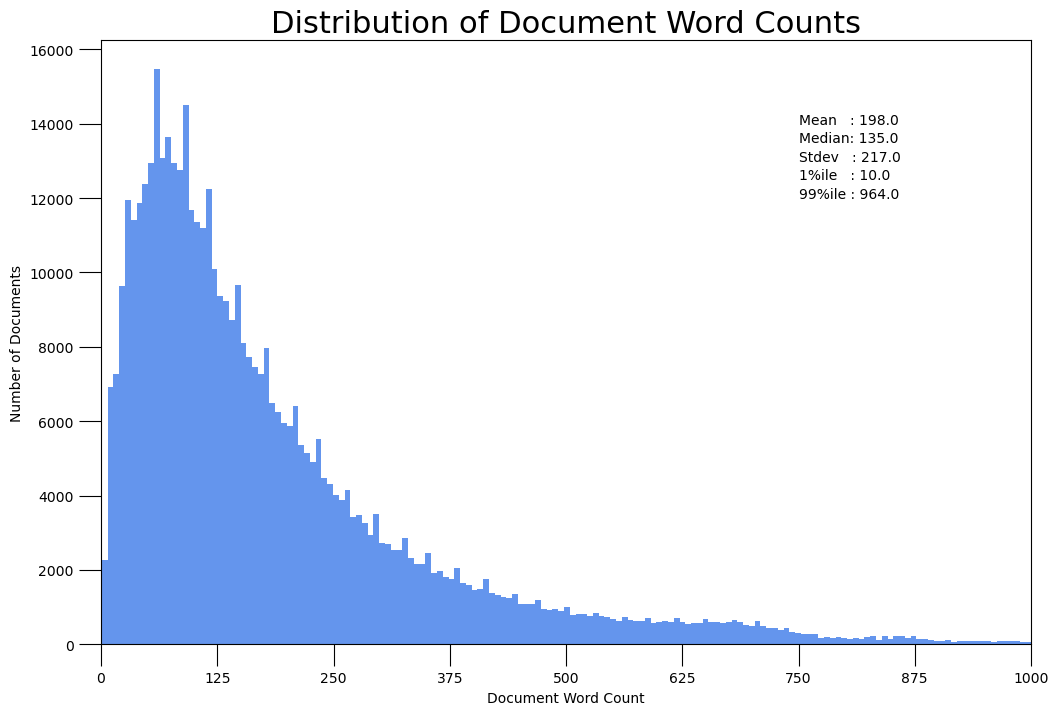

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

doc_lens = [len(d.split(' ')) for d in df_dominant_topic.Text]

plt.figure(figsize=(12,8), dpi=100)
plt.hist(doc_lens, bins = 1000, color='cornflowerblue')
plt.text(750, 14000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 13500, "Median: " + str(round(np.median(doc_lens))))
plt.text(750, 13000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750, 12500, "1%ile   : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750, 12000, "99%ile : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

The same graph has been computed for each topic. The black line shows the distribution of the important words in that topic over all topics.

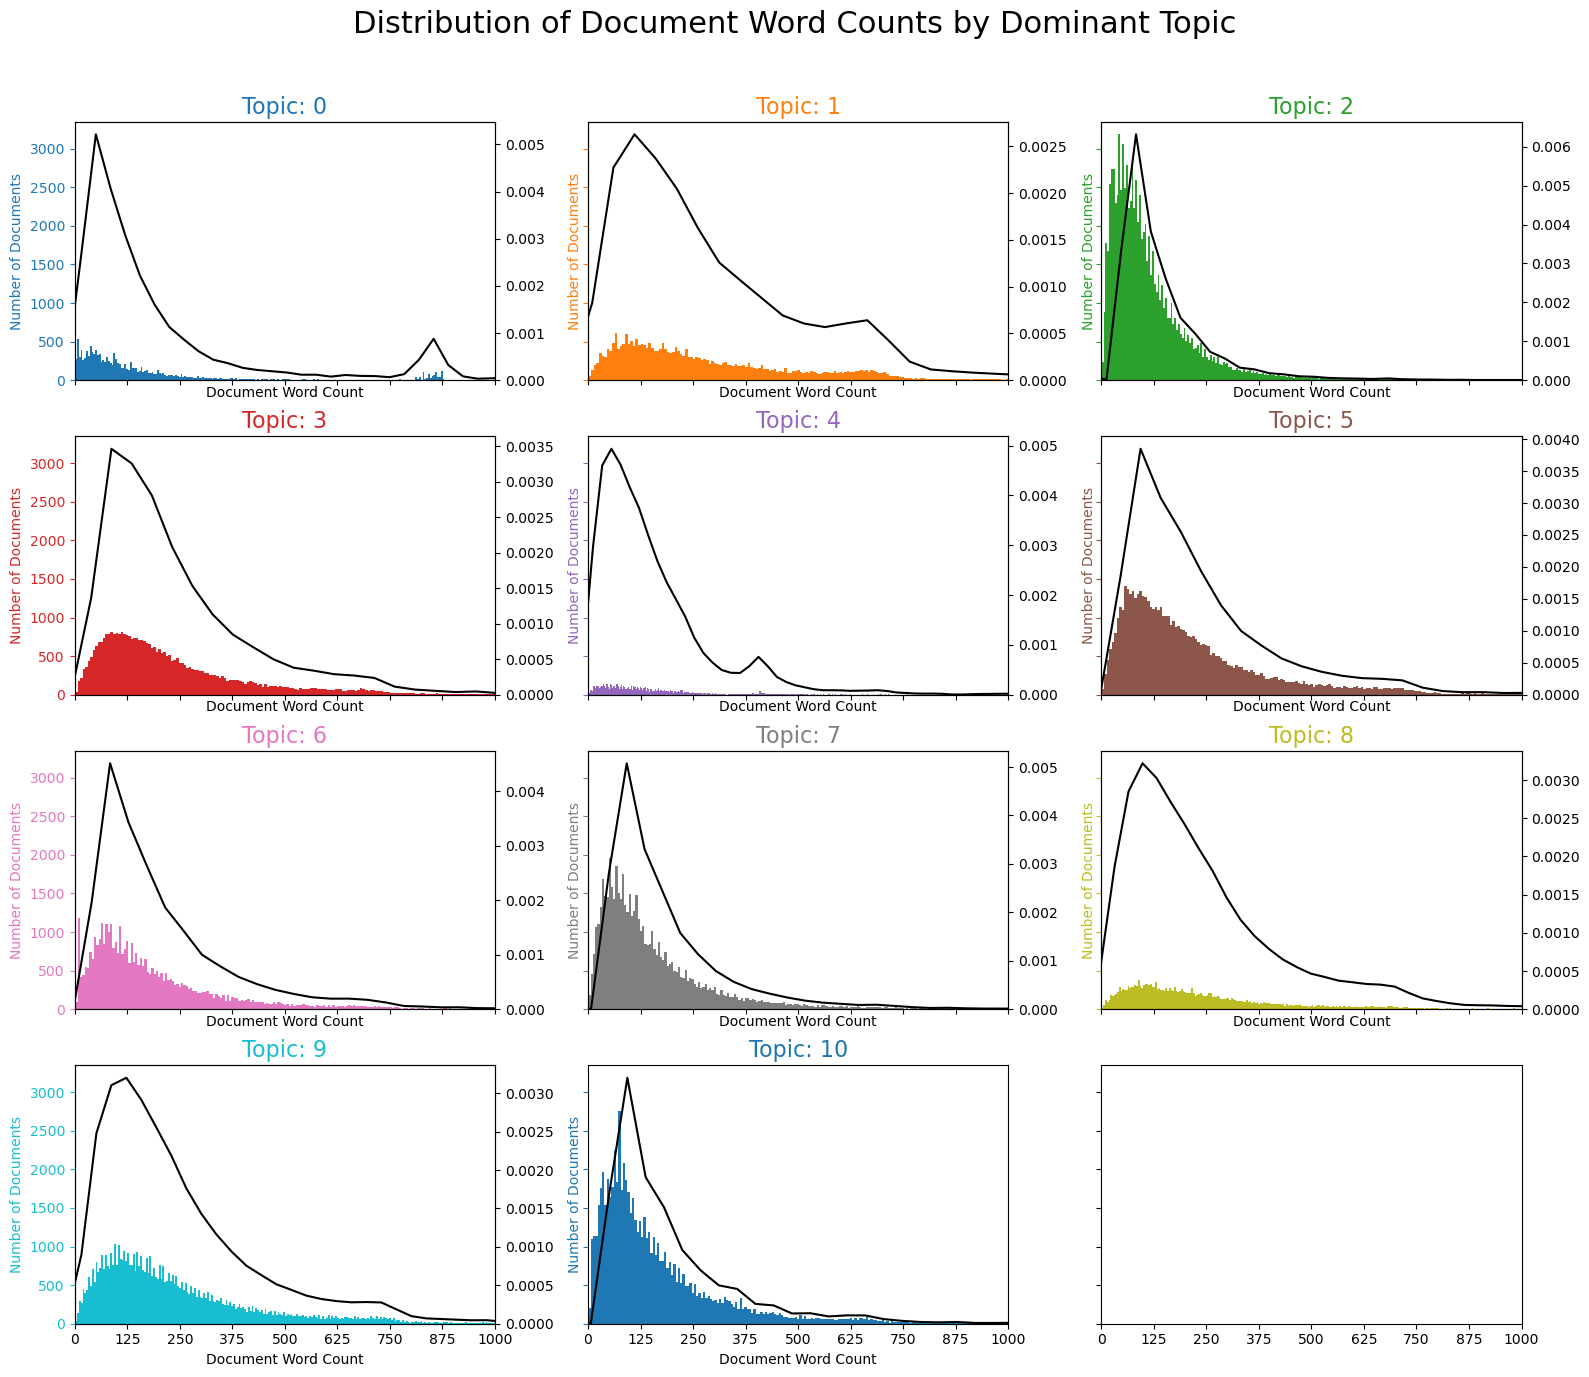

In [26]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(4, 3, figsize=(16,14), dpi=100, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i > 10:
        plt.gca().axis('off')
        break
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d.split(' ')) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i%10])
    ax.tick_params(axis='y', labelcolor=cols[i%10], color=cols[i%10])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i%10])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i%10]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

The following is a word cloud for each topic with a maximum of the 15 most frequent dictionary words in each topic.

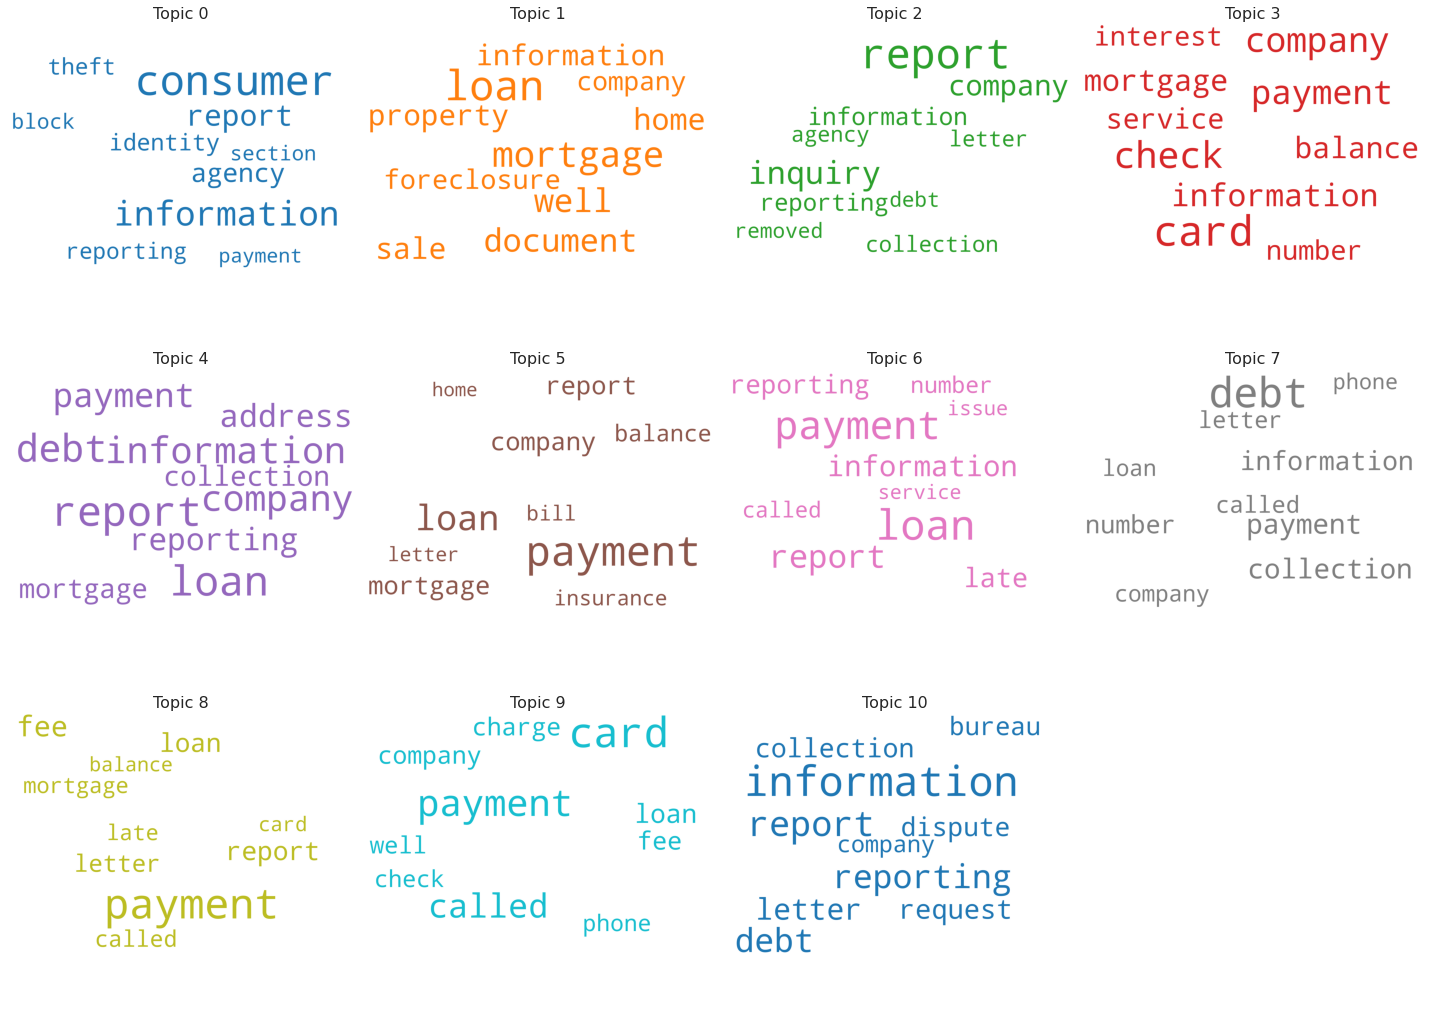

In [592]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  color_func=lambda *args, **kwargs: cols[i%10],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=11, formatted=False)

fig, axes = plt.subplots(3, 4, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    plt.gca().axis('off')
    if i > 10: break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

By manually checking these topic word clouds and reading some complaints per topic, the conclusion is that this a good clustering and that there is not so much overlapp between clusters.

The graph visualizations have been inspired by https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

## Classification

The classification with the product label gave results that weren't bad, but it wasn't ideal. Certain clusters had more wrong classifications which insist that the product label wasn't a good clustering of the complaints. Using classification would also be proof that the clusters aquired through LDA are good clusters.

In [5]:
import pandas as pd

filename = 'dataset_new_clusters.csv'
dataset_new_clusters = pd.read_csv(filename) 

In [6]:
import re

# drop columns that aren't going to be used
dataset_new_clusters = dataset_new_clusters.drop(['Unnamed: 0', 'Date received', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Company response to consumer', 'Timely response?', 'Date sent to company', 'Consumer disputed?', 'Complaint ID'], axis=1)
# remove useless text parts
dataset_new_clusters['Consumer complaint narrative'] = dataset_new_clusters['Consumer complaint narrative'].replace(to_replace=r'xx/xx/\d{4}|XX/XX/\d{4}|\d\d/\d\d/\d{4}|xx/xx/\d{2}|XX/XX/\d{2}|\d\d/\d\d/\d{2}|xx+|XX+|{|}|\$\d+(\.\d+)?', value='', regex=True)
# replace consecutive spaces by only one space
dataset_new_clusters['Consumer complaint narrative'] = dataset_new_clusters['Consumer complaint narrative'].replace(to_replace=r'\s\s+', value=' ', regex=True)

In [7]:
%%time

dataset_new_clusters['Consumer complaint narrative'] = clean_col(dataset_new_clusters['Consumer complaint narrative'])

CPU times: user 23min 11s, sys: 2.07 s, total: 23min 13s
Wall time: 23min 13s


### Multinomial Naive Bayes classifier 

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y = dataset_new_clusters['LDA clusters'] 
X_train, X_test, y_train, y_test = train_test_split(dataset_new_clusters['Consumer complaint narrative'], y, random_state=None ,test_size=0.33, stratify=y)

print(X_train.shape)
print(X_test.shape)

clf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(encoding='latin-1', stop_words=stop_words)),
    ('mnb_clf', OneVsRestClassifier(MultinomialNB(class_prior=None))),
])

parameters  = {
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': ('l1', 'l2', None),
    'tfidf__min_df': [1, 5, 10, 25, 50],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'mnb_clf__estimator__fit_prior':  [True, False],
    'mnb_clf__estimator__alpha': (1, 0.1, 0.01, 0.001)
}

clf = GridSearchCV(clf_pipeline, parameters, cv=5, n_jobs=-1, verbose=10)
grid_result = clf.fit(X_train, y_train)

best_params = grid_result.best_params_

print(best_params)
print(classification_report(y_test, clf.predict(X_test), digits=4))

(322165,)
(158679,)
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 1

{'mnb_clf__estimator__alpha': 0.01, 'mnb_clf__estimator__fit_prior': False, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l1', 'tfidf__sublinear_tf': False}
              precision    recall  f1-score   support

           0     0.8196    0.7057    0.7584      4010
           1     0.7731    0.8843    0.8250     10537
           2     0.8660    0.8613    0.8637     28586
           3     0.8419    0.6712    0.7469     10917
           4     0.7990    0.4418    0.5689      2816
           5     0.7941    0.8051    0.7995     19349
           6     0.8305    0.7517    0.7891     12100
           7     0.7872    0.9150    0.8463     19089
           8     0.7455    0.5299    0.6195      7563
           9     0.7542    0.8332    0.7918     21870
          10     0.8707    0.8845    0.8776     21842

    accuracy                         0.8132    158679
   macro avg     0.8074    0.7531    0.7715    158679
weighted avg     0.8144    0.8132    0.8100    158679



In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y = dataset_new_clusters['LDA clusters'] 
X_train, X_test, y_train, y_test = train_test_split(dataset_new_clusters['Consumer complaint narrative'], y, random_state=None ,test_size=0.33, stratify=y)

print(X_train.shape)
print(X_test.shape)

clf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1, 2), norm='l1', sublinear_tf=False, encoding='latin-1', stop_words=stop_words)),
    ('mnb_clf', OneVsRestClassifier(MultinomialNB(alpha=0.01, fit_prior=False, class_prior=None))),
])

clf = clf_pipeline.fit(X_train, y_train)
prediction = clf_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

(322165,)
(158679,)
Test accuracy is 0.8134850862432962


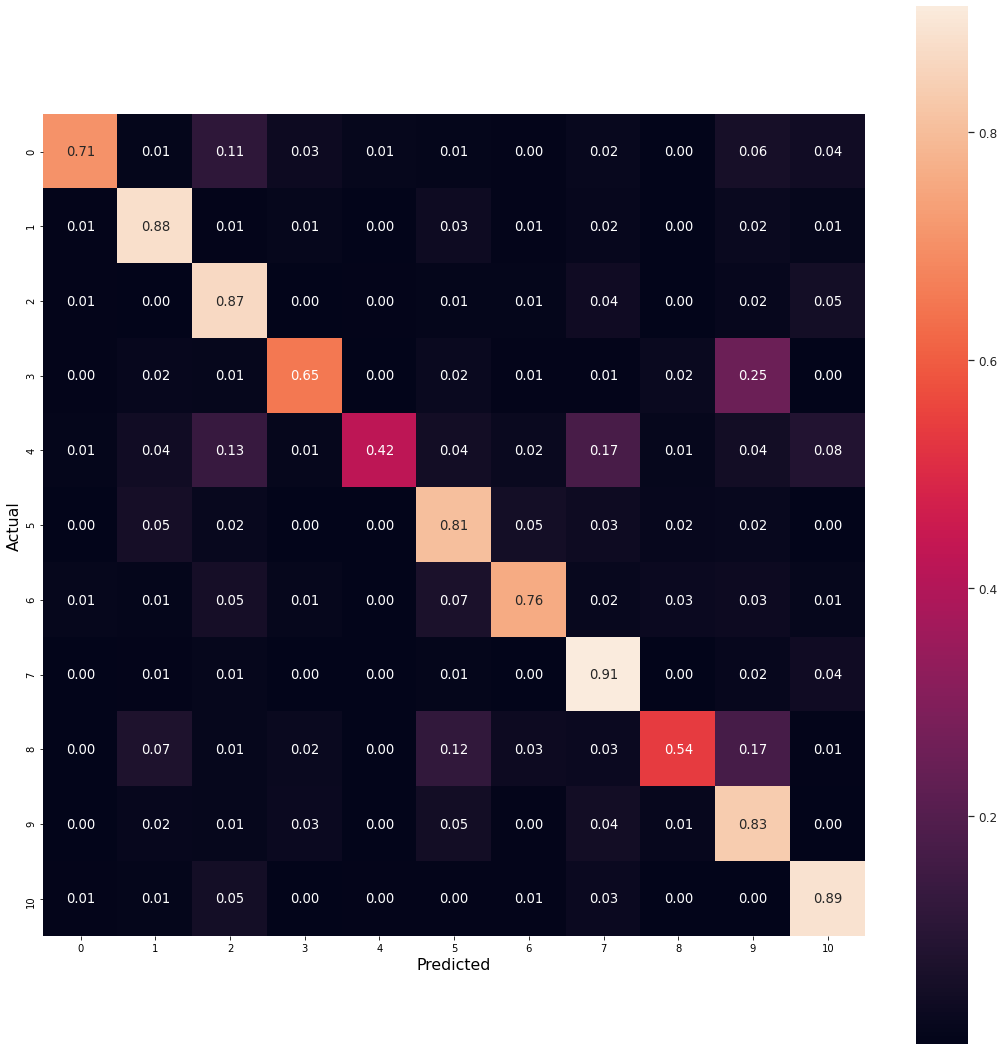

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, prediction, normalize='true')
fig, ax = plt.subplots(figsize=(15,15))
plt.tight_layout()
sns.set(font_scale=1.1)
sns.heatmap(conf_mat, annot=True, fmt='.2f', square=True, 
            xticklabels=range(0,11), 
            yticklabels=range(0,11))
plt.ylabel('Actual', size='large')
plt.xlabel('Predicted', size='large')

plt.show()

The multinomial naive bayes classifier gave an accuracy of 75.28% with the product label. The accuracy with the new clusters went up to 81.35%. There are few clusters with some wrong classification. So there is an improvement in accuracy and cluster uniqueness.

### Support Vector Machine classifier

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
stop_words = set(stopwords.words('english'))

y = dataset_new_clusters['LDA clusters']
X_train, X_test, y_train, y_test = train_test_split(dataset_new_clusters['Consumer complaint narrative'], y, random_state=None ,test_size=0.33, stratify=y)

print(X_train.shape)
print(X_test.shape)

clf_pipeline = Pipeline([
    ('vectorize', CountVectorizer(ngram_range=(1,2), stop_words=stop_words)),
    ('tfidf', TfidfTransformer()),
    ('svc_clf', LinearSVC(multi_class='ovr')),
])

parameters  = {
    'vectorize__min_df': [0.01, 0.05, 0.1],
    'vectorize__max_df': [0.4, 0.6, 0.8],
    'tfidf__norm': ('l1', 'l2'),
    'tfidf__use_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'svc_clf__loss': ('hinge', 'squared_hinge'),
}

clf = GridSearchCV(clf_pipeline, parameters, cv=5, n_jobs=-1, verbose=10)
grid_result = clf.fit(X_train, y_train)

best_params = grid_result.best_params_

print(best_params)
print(classification_report(y_test, clf.predict(X_test), digits=4))

(322165,)
(158679,)
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 25.2min
/opt/conda/lib/python3.7/site-packages/joblib/externals

{'svc_clf__loss': 'squared_hinge', 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': False, 'tfidf__use_idf': False, 'vectorize__max_df': 0.4, 'vectorize__min_df': 0.01}
              precision    recall  f1-score   support

           0     0.8299    0.7444    0.7848      4010
           1     0.8203    0.8139    0.8171     10537
           2     0.8482    0.9068    0.8765     28586
           3     0.7801    0.6823    0.7279     10917
           4     0.7712    0.4837    0.5945      2816
           5     0.8093    0.8246    0.8169     19349
           6     0.8119    0.7833    0.7973     12100
           7     0.8399    0.8942    0.8662     19089
           8     0.7622    0.6213    0.6846      7563
           9     0.7950    0.8323    0.8132     21870
          10     0.8748    0.8802    0.8775     21842

    accuracy                         0.8251    158679
   macro avg     0.8130    0.7697    0.7870    158679
weighted avg     0.8235    0.8251    0.8227    158679



In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
stop_words = set(stopwords.words('english'))

y = dataset_new_clusters['LDA clusters']
X_train, X_test, y_train, y_test = train_test_split(dataset_new_clusters['Consumer complaint narrative'], y, random_state=None ,test_size=0.33, stratify=y)

print(X_train.shape)
print(X_test.shape)

clf_pipeline = Pipeline([
    ('vectorize', CountVectorizer(min_df=0.01, max_df=0.4, ngram_range=(1,2), stop_words=stop_words)),
    ('tfidf', TfidfTransformer(norm='l2', sublinear_tf=False, use_idf=False)),
    ('svc_clf', LinearSVC(multi_class='ovr', loss='squared_hinge')),
])

clf = clf_pipeline.fit(X_train, y_train)
prediction = clf_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

(322165,)
(158679,)
Test accuracy is 0.8269462247682428


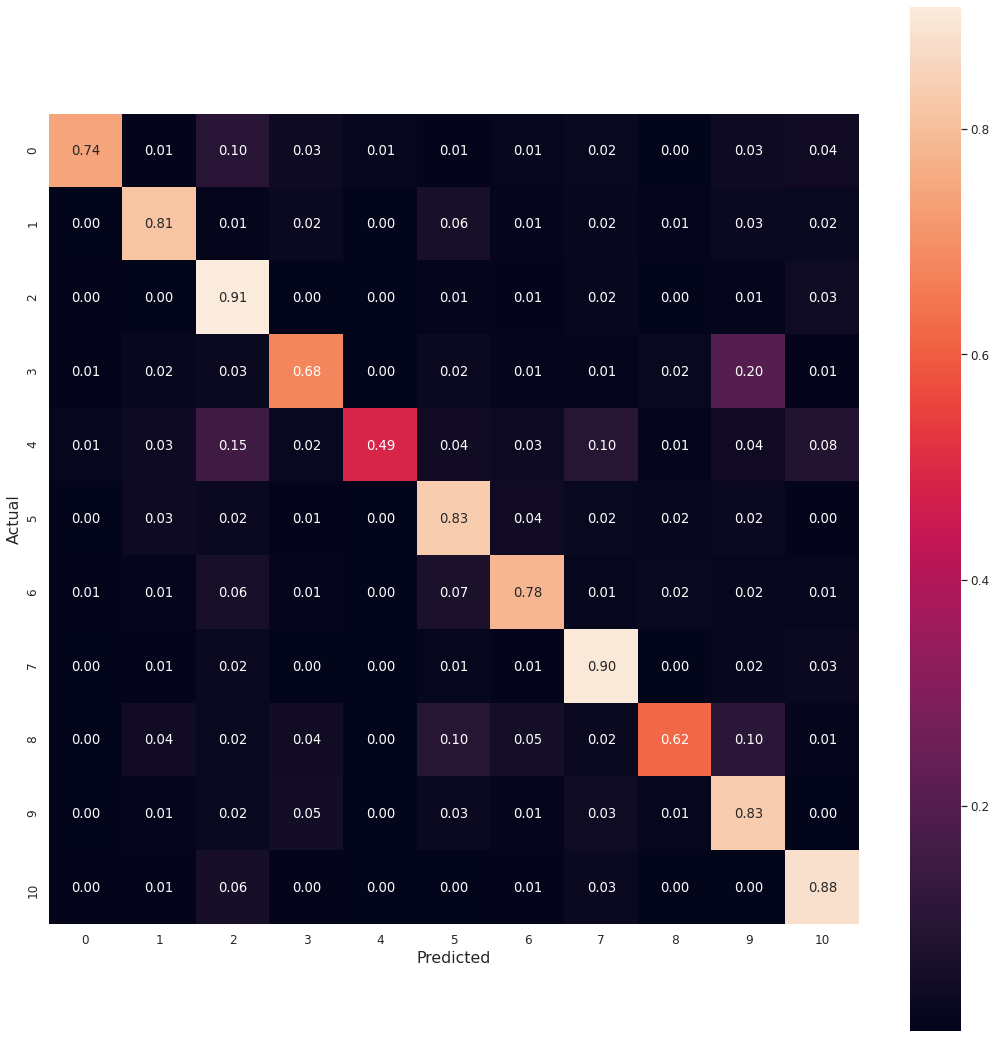

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, prediction, normalize='true')
fig, ax = plt.subplots(figsize=(15,15))
plt.tight_layout()
sns.set(font_scale=1.1)
sns.heatmap(conf_mat, annot=True, fmt='.2f', square=True, 
            xticklabels=range(0,11), 
            yticklabels=range(0,11))
plt.ylabel('Actual', size='large')
plt.xlabel('Predicted', size='large')

plt.show()

The SVM classifier gave an accuracy of 71.84% with the product label. The accuracy with the new clusters went up to 82.69%. There are few clusters with some wrong classification. So there is an improvement in accuracy and cluster uniqueness.

### Recurrent neural network with LSTM component

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
stop_words = set(stopwords.words('english')) 
lemma=WordNetLemmatizer()
import re

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

In [11]:
y = dataset_new_clusters['LDA clusters']
X, X_test, Y, y_test = train_test_split(dataset_new_clusters['Consumer complaint narrative'], y, random_state=None ,test_size=0.33, stratify=y)

In [12]:
all_words = ' '.join(X)
all_words = word_tokenize(all_words)
dist = FreqDist(all_words)

unique_word_count = len(dist)
print(unique_word_count)

89090


In [13]:
tokenizer = Tokenizer(num_words = unique_word_count)
tokenizer.fit_on_texts(X)
x_train_tokens = tokenizer.texts_to_sequences(X)
x_test_tokens = tokenizer.texts_to_sequences(X_test)

In [14]:
import numpy as np

num_tokens = [len(tokens) for tokens in x_train_tokens]
num_tokens = np.array(num_tokens)

In [15]:
np.mean(num_tokens)

85.39416137693418

In [16]:
np.max(num_tokens)

2836

In [17]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

273

In [18]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9572486148402216

In [19]:
pad = 'pre'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens, padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens, padding=pad, truncating=pad)

In [20]:
values = array(Y.values.ravel())
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y_encoded = onehot_encoder.fit_transform(integer_encoded)
print(Y_encoded)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [21]:
values_0 = array(y_test.values.ravel())
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values_0)
onehot_encoder = OneHotEncoder(sparse = False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y_encoded_test = onehot_encoder.fit_transform(integer_encoded)
print(Y_encoded_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [113]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

model = Sequential()
model.add(Embedding(unique_word_count, 128))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 128)         11403520  
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, None, 128)         0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               91600     
_________________________________________________________________
dense_15 (Dense)             (None, 11)                1111      
Total params: 11,496,231
Trainable params: 11,496,231
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
from keras.callbacks import EarlyStopping

epochs = 10
batch_size = 1024 #128

history = model.fit(x_train_pad, Y_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 289948 samples, validate on 32217 samples
Epoch 1/10
289948/289948 [==============================] - 377s 1ms/step - loss: 1.2922 - accuracy: 0.5575 - val_loss: 0.7785 - val_accuracy: 0.7418
Epoch 2/10
289948/289948 [==============================] - 362s 1ms/step - loss: 0.7678 - accuracy: 0.7457 - val_loss: 0.6243 - val_accuracy: 0.7961
Epoch 3/10
289948/289948 [==============================] - 361s 1ms/step - loss: 0.6140 - accuracy: 0.7946 - val_loss: 0.5220 - val_accuracy: 0.8279
Epoch 4/10
289948/289948 [==============================] - 359s 1ms/step - loss: 0.5125 - accuracy: 0.8262 - val_loss: 0.4575 - val_accuracy: 0.8426
Epoch 5/10
289948/289948 [==============================] - 361s 1ms/step - loss: 0.4152 - accuracy: 0.8554 - val_loss: 0.3910 - val_accuracy: 0.8601
Epoch 6/10
289948/289948 [==============================] - 359s 1ms/step - loss: 0.3452 - accuracy: 0.8781 - val_loss: 0.3532 - val_accuracy: 0.8741
Epoch 7/10
289948/289948 [=======================

In [115]:
%%time
result = model.evaluate(x_test_pad, Y_encoded_test)

158679/158679 [==============================] - 237s 1ms/step
CPU times: user 11min 26s, sys: 1min 48s, total: 13min 15s
Wall time: 3min 57s


In [116]:
print("Accuracy: {0:.2%}".format(result[1]))

Accuracy: 89.54%


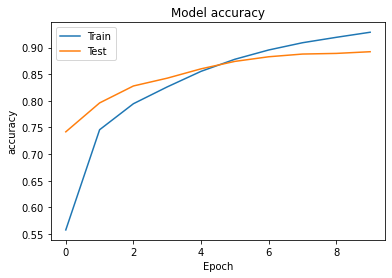

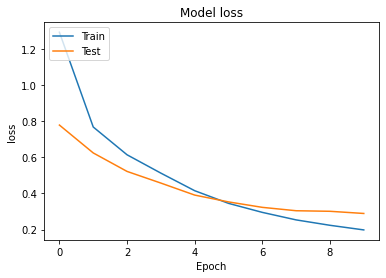

In [117]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    # Plot training & validation accuracy values
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title('Model '+string)
    plt.ylabel(string)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

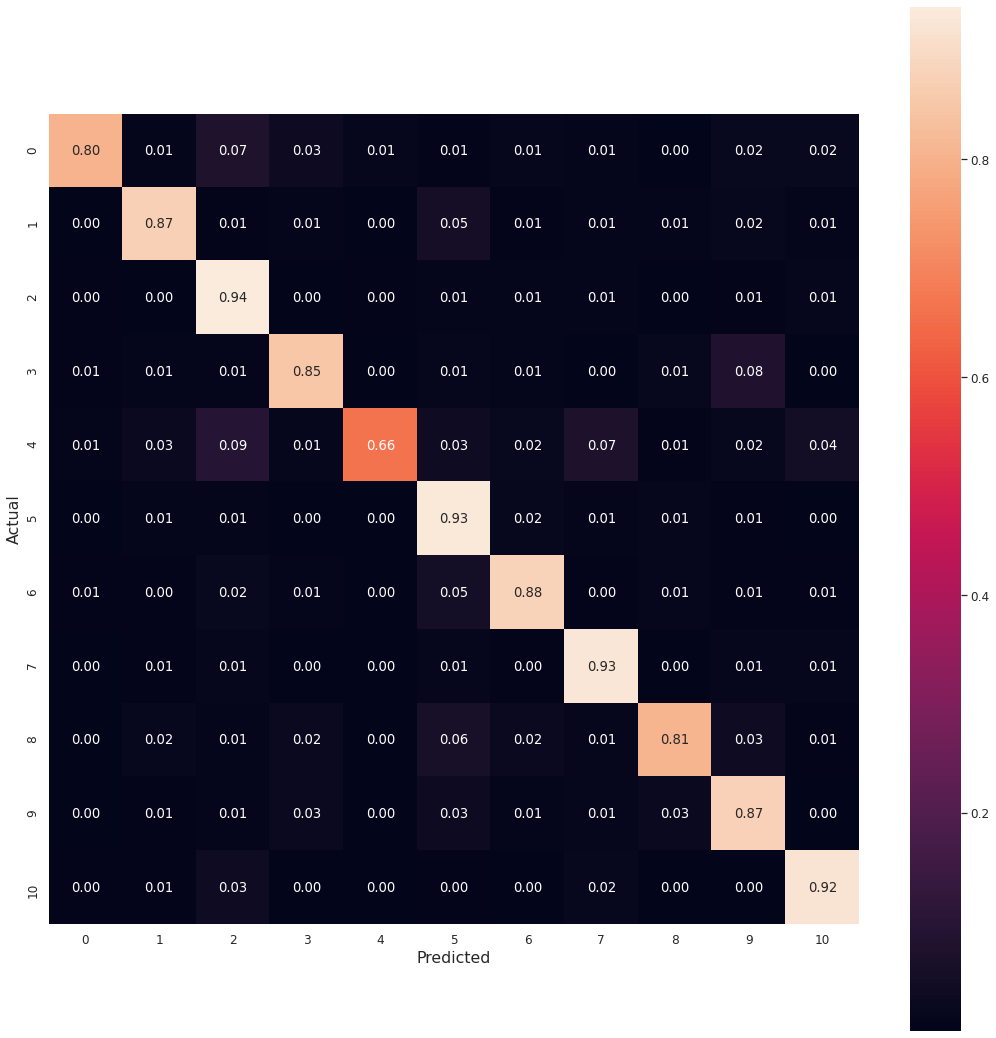

In [162]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

prediction = model.predict_classes(x_test_pad)

conf_mat = confusion_matrix(Y_encoded_test.argmax(axis=1), prediction, normalize='true')
fig, ax = plt.subplots(figsize=(15,15))
plt.tight_layout()
sns.set(font_scale=1.1)
sns.heatmap(conf_mat, annot=True, fmt='.2f', square=True, 
            xticklabels=range(0,11), 
            yticklabels=range(0,11))
plt.ylabel('Actual', size='large')
plt.xlabel('Predicted', size='large')

plt.show()

The previous version of the neural network had a lot of overfitting and an accuracy of 74.46%. The improved RNN has a lot less overfitting and has an accuracy of 89.54%. This is an improvement in terms of less overfitting and accuracy. The model could be trained up to 5 epochs because starting at epoch 6 accuracy doesn't improve anymore on the validation set.

The confusion matrix shows that all clusters have a good uniqueness and there are very few wrong classifications. The recurrent "bad" cluster is cluster 4 in all 3 classifiers, the reason for this is that this cluster is the smallest cluster which makes it more difficult to classify documents from that cluster.

## Automatic summarization

As some complaints are quite large to analyse, it is useful to get a summarization of that complaint.
For summarization, several techniques are used. Not all of them work as expected. The techniques used are:
1. Weight Frequency
2. Gensim
3. TextRank,
4. PyTextRank

These methods will construct summarization based on the sentences used in the original complaint. They will not automaticaly generate new sentences out of the most import words.

In [687]:
import pandas as pd

filename = 'dataset_new_clusters.csv'
dataset_new_clusters = pd.read_csv(filename) 

In [688]:
dataset_new_clusters.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,LDA clusters
0,250000,02/17/17,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,"My husband XXXX XXXX passed away on XXXX/XXXX/XXXX. As you can imagine, I was devastated. We had been married for almost 50 years. He was the father of my children, my business partner and my partner in life. \r\n\r\nMy XXXX for the first several months after XXXX passed away. Everyone kept asking me thousands of questions about our finances, our house, our vehicles, life insurance, etc., but I had no clue how to answer. XXXX had always handled our finances. I eventually figured it all out, and I transitioned most everything into my name within a few months EXCEPT our mortgage with Wells Fargo. \r\n\r\nFor some reason, it was very difficult for me to make the call to Wells Fargo. I do n't know why. We were in a good position financially, and I continued to make all payments on time, but I still did n't want to make the call. In hindsight, I think I knew the call to WF would initiate closure to a life I was n't ready to close. I knew as soon as XXXX 's name was removed from our mort...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,WELLS FARGO & COMPANY,TX,750XX,Older American,Consent provided,Web,02/17/17,Closed with explanation,Yes,No,2350810,1
1,250001,03/31/17,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,"Extortion excess escrow ; with threatened Foreclosure for amounts not due ; attachments define the case with proofs ; opposing counsel states the Stipulated Injunctive order CASE XXXX Document XXXX Filed XX/XX/2015 as brought by FTC and CFPB are not enforceable between customers and Ditech Financial LLC , therefore they did no wrong that can be enforced, or the gist similar thereof ; Phone records and specific calls can be identified with key information, but implications are that the recording of such collections calls by Ditech as required to be kept at 90 % per the agreement, are not discoverable to an individual consumer Ditech has abused",Company believes it acted appropriately as authorized by contract or law,Ditech Financial LLC,MI,48072,None,Consent provided,Web,03/31/17,Closed with explanation,Yes,Yes,2413884,1
2,250002,04/07/17,Debt collection,"Other (i.e. phone, health club, etc.)",Improper contact or sharing of info,Talked to a third party about my debt,I do not have a contract with Diversified Consultants. There is no right to substitute someone or some entity that was not on an original contract. It is not allowed. They are reporting on all XXXX of my credit reports and they need to be removed.,None,"Diversified Consultants, Inc.",MO,631XX,None,Consent provided,Web,04/07/17,Closed with explanation,Yes,No,2424349,10
3,250003,03/24/17,Consumer Loan,Title loan,Payment to acct not credited,None,"A 20 year loan at .0875 simple interest, in XX/XX/XXXX and ongoing, we have made {$17000.00} in principal only payments, as allowed by our original contract ( XX/XX/XXXX ) and interest has been taken out of those payments. There are other anomalies in the account history, that are different from the actuarial table. We have not been given an explanation that is much more than making the numbers say what they want. We have been trying to pay this off since XX/XX/XXXX in person at PNC Bank XXXX Fl. and 26 phone calls, many not answered or returned, since then. The payoff amount is always about {$4000.00} high by my arithmetic. PNC Bank and we have been going around on this since late XX/XX/XXXX. It is my opinion they ( PNC Bank ) is stealing {$4000.00} from us and with the continuous avoidance and runaround {$6.00} a day in interest since XX/X

In [1]:
from gensim.summarization.summarizer import summarize
import re
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
import string
from heapq import nlargest
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

unable to import 'smart_open.gcs', disabling that module


### Weighted Frequency

This method is similar to weighted averages of Word Embeddings, but uses the maximum frequency term in the text as a weighted factor.

In [6]:
#load stopwords
stop = nltk.corpus.stopwords.words('english')

def remove_stopwords(sentence):
        filtered_sentence = " ".join([i for i in sentence if i not in stop])
        return filtered_sentence
    
amount_sentences = 4

#Split paragraph into sentences. We want to know how similar each sentence is with each other.
def summary_frequency(sentence):
    sentences = (sent_tokenize(sentence))

    #Pre-process your text. Remove punctuation, special characterts, numbers, etc. As the only thing we care
    #about are the actual words in the text.
    clean_sentences = clean_col(sentences)
    
    word_frequencies = {}
    for i in range(len(clean_sentences)):
        for word in nltk.word_tokenize(clean_sentences[i]):
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1
                
    maximum_frequency = max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequency)
        
    #Apply scores to each UNCLEANED SENTENCE
    sentence_scores = {}
    for sent in sentences:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]

    #Choose number of sentences you want in your summary
    summary_sentences = nlargest(amount_sentences, sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)
    print("\nOriginal text:\n" + sentence)
    print("\nSummary cluster:\n" + summary)
    print("\n")

In [7]:
for i in range(0,5):
    summary_frequency(dataset["Consumer complaint narrative"][i])


Original text:
I have complained many times that the credit reporting by Experian is inaccurate and they always just say wait awhile, it will be fixed later and yet it never is. They are incapable of providing accurate information and do not take responsibility for their errors. This is a fake service, designed to serve only their needs and not the consumer 's needs. I can not find any way to cancel and when I mention it on the phone I am immediately disconnected. 
I want to be a part of the class action lawsuit against them since they are responsible for reducing my credit rating, releasing my personal information and my fraud complaints have multiplied over the last 2-3 years. I have spoken to many ineffectual and uncaring agents on their phone support lines and am just tired of paying them to degrade my credit for random incorrect reasons ( like I paid a utility bill with another bank account ) and not raising it for legitimate things like paying off thousands of dollars of debt, g

All the complaints are summarized into 2 sentences (as given as an argument to the method), except for the last complaint.
The last complaint only returns one sentence, which is not useful as a summarization. This sentence doesn't explain the real situation of the complaint. The other complaints have a semi-useful summarization.

### Gensim

Next used is the summarize method of Gensim, an out of the box solution.

In [8]:
from gensim.summarization.summarizer import summarize
from nltk.tokenize import sent_tokenize

def summarize_gensim(text, count):
    print("Original text:\n", text, "\n\nSummarize:")
    if(len(sent_tokenize(text)) < count):
        print(text)
    else:
        print(summarize(text))
    print("\n")

for i in range(0,5):
    summarize_gensim(dataset["Consumer complaint narrative"][i], 2)

Original text:
 I have complained many times that the credit reporting by Experian is inaccurate and they always just say wait awhile, it will be fixed later and yet it never is. They are incapable of providing accurate information and do not take responsibility for their errors. This is a fake service, designed to serve only their needs and not the consumer 's needs. I can not find any way to cancel and when I mention it on the phone I am immediately disconnected. 
I want to be a part of the class action lawsuit against them since they are responsible for reducing my credit rating, releasing my personal information and my fraud complaints have multiplied over the last 2-3 years. I have spoken to many ineffectual and uncaring agents on their phone support lines and am just tired of paying them to degrade my credit for random incorrect reasons ( like I paid a utility bill with another bank account ) and not raising it for legitimate things like paying off thousands of dollars of debt, g

These results are not as expected. There is no real summarization.
Most upsetting result is the last complaint, where the summarization algorithm of Gensim failed and didn't return any summary.   

### TextRank

TextRank is an extractive and unsupervised text summarization technique. It will calculate the similarity between any two sentences and store them in a square matrix. The sentences with the highest similarity between all of the sentences will be used as summarization sentences.

In [10]:
import networkx as nx
import numpy as np
 
from nltk.tokenize.punkt import PunktSentenceTokenizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
 
def textrank(document):
    # Split in sentences
    sentence_tokenizer = PunktSentenceTokenizer()
    sentences = sentence_tokenizer.tokenize(document)
 
    # Make BoW matrix and normalize it
    bow_matrix = CountVectorizer().fit_transform(sentences)
    normalized = TfidfTransformer().fit_transform(bow_matrix)
 
    # Make a similarity graph
    similarity_graph = normalized * normalized.T
 
    nx_graph = nx.from_scipy_sparse_matrix(similarity_graph)
    scores = nx.pagerank(nx_graph)
    return sorted(((scores[i],s) for i,s in enumerate(sentences)),
                  reverse=True)

def summary_textrank(text, count):
    print("Original:\n", text, "\n\nSummary:")
    
    sents = textrank(text)
    res = ""
    
    if (len(sents) < count):
        print(text)
    else:
        for s in range(0,count):
            res += sents[s][1]
    print(res, "\n\n\n")

In [11]:
for i in range(0,5):
    summary_textrank(dataset["Consumer complaint narrative"][i], 2)

Original:
 I have complained many times that the credit reporting by Experian is inaccurate and they always just say wait awhile, it will be fixed later and yet it never is. They are incapable of providing accurate information and do not take responsibility for their errors. This is a fake service, designed to serve only their needs and not the consumer 's needs. I can not find any way to cancel and when I mention it on the phone I am immediately disconnected. 
I want to be a part of the class action lawsuit against them since they are responsible for reducing my credit rating, releasing my personal information and my fraud complaints have multiplied over the last 2-3 years. I have spoken to many ineffectual and uncaring agents on their phone support lines and am just tired of paying them to degrade my credit for random incorrect reasons ( like I paid a utility bill with another bank account ) and not raising it for legitimate things like paying off thousands of dollars of debt, gettin

The summarizations are better then previous techniques, yet not perfect. It does make quite large summarizations (because of large sentences) which is not preferable. It would be useful to have a technique which can even break up sentences in smaller pieces and use these pieces for the summarization.

### PyTextRank

PyTextRank does exactly that. It uses the nlp method of Spacy for splitting up the complaint in several import sentence pieces, and out of these pieces makes the summary.

In [12]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [13]:
import spacy
import pytextrank
from math import sqrt
from operator import itemgetter

def summarize_pytextrank(text, count):
    # load a spaCy model, depending on language, scale, etc.
    nlp = spacy.load("en_core_web_sm")

    # add PyTextRank to the spaCy pipeline
    tr = pytextrank.TextRank()
    nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

    doc = nlp(text)

    sent_bounds = [ [s.start, s.end, set([])] for s in doc.sents ]

    limit_phrases = 4

    phrase_id = 0
    unit_vector = []

    for p in doc._.phrases:    
        unit_vector.append(p.rank)

        for chunk in p.chunks:       
            for sent_start, sent_end, sent_vector in sent_bounds:
                if chunk.start >= sent_start and chunk.start <= sent_end:
                    sent_vector.add(phrase_id)
                    break

        phrase_id += 1

        if phrase_id == limit_phrases:
            break

    sum_ranks = sum(unit_vector)
    unit_vector = [ rank/sum_ranks for rank in unit_vector ]


    sent_rank = {}
    sent_id = 0

    for sent_start, sent_end, sent_vector in sent_bounds:
        sum_sq = 0.0

        for phrase_id in range(len(unit_vector)):
            if phrase_id not in sent_vector:
                sum_sq += unit_vector[phrase_id]**2.0

        sent_rank[sent_id] = sqrt(sum_sq)
        sent_id += 1

    sorted(sent_rank.items(), key=itemgetter(1))
    limit_sentences = count

    sent_text = {}
    sent_id = 0

    for sent in doc.sents:
        sent_text[sent_id] = sent.text
        sent_id += 1

    num_sent = 0

    for sent_id, rank in sorted(sent_rank.items(), key=itemgetter(1)):
        print(sent_text[sent_id])
        num_sent += 1

        if num_sent == limit_sentences:
            break

In [14]:
for i in range(0,5):
    print("Original:\n", dataset["Consumer complaint narrative"][i], "\n\nSummary:")
    summarize_pytextrank(dataset["Consumer complaint narrative"][i], 2)
    print("\n\n\n")

Original:
 I have complained many times that the credit reporting by Experian is inaccurate and they always just say wait awhile, it will be fixed later and yet it never is. They are incapable of providing accurate information and do not take responsibility for their errors. This is a fake service, designed to serve only their needs and not the consumer 's needs. I can not find any way to cancel and when I mention it on the phone I am immediately disconnected. 
I want to be a part of the class action lawsuit against them since they are responsible for reducing my credit rating, releasing my personal information and my fraud complaints have multiplied over the last 2-3 years. I have spoken to many ineffectual and uncaring agents on their phone support lines and am just tired of paying them to degrade my credit for random incorrect reasons ( like I paid a utility bill with another bank account ) and not raising it for legitimate things like paying off thousands of dollars of debt, gettin

These results are satisfying, as a summary is made for every complaint, without being to big of a summary. Even the most difficult complaint, in this example, has been summarised.

It is important to notice that the last summary consists of 2 pieces of the same sentence. The 2 pieces are put in reverse order.

The sentences themself (or the pieces in them who are used as sentences) are not always correct in syntax, but they do give a clear view of the complaint.

## Member workload

| Name | Subject | Date |
| :--- | :--- | :--- |
| All | Meeting to discuss sprint 3. | April 28, 2020 |
| Gillis Werrebrouck | Add final notebook. | April 29, 2020 |
| Gillis Werrebrouck | Datacleaning and outlier detection/removal. | May 1, 2020 |
| Gillis Werrebrouck | Run hierarchical clustering model. | May 2, 2020 |
| Christophe Beke | Divide complaints per cluster & make 3 random complaints per cluster. | May 4, 2020 |
| All | Manually reading the complaints per cluster for confirmation. Range distances: Gillis (3), Christophe (4, 9), Robin (5, 6, 8). | May 4, 2020 |
| Christophe Beke | Added the cluster numbers to the Dataframe for further research | May 5, 2020 |
| Gillis Werrebrouck | Trying to get hierarchical clustering working correctly and with good clusters. | May 7, 2020 |
| Robin De Zwaef | Research Quality metric | May 7, 2020 |
| Gillis Werrebrouck | Trying to get hierarchical clustering working correctly and with good clusters. | May 8, 2020 |
| Gillis Werrebrouck | Trying to get hierarchical clustering working correctly and with good clusters. | May 10, 2020 |
| Gillis Werrebrouck | LDA clustering research | May 11, 2020 |
| Gillis Werrebrouck | LDA clustering implementation | May 13, 2020 |
| Gillis Werrebrouck | LDA clustering implementation | May 14, 2020 |
| All | LDA clustering meeting | May 15, 2020 |
| Christophe Beke | Research for text summarization | May 19, 2020 |
| Gillis Werrebrouck | LDA clustering statistics | May 19, 2020 |
| Gillis Werrebrouck & Christophe Beke | Meeting about LDA statistics | May 19, 2020 |
| Gillis Werrebrouck | LDA clustering statistics | May 20, 2020 |
| Christophe Beke | Implementing text summarization | May 20, 2020 |
| All | LDA clustering meeting | May 21, 2020 |
| Gillis Werrebrouck | Classification on the new clusters with MNBayes, SVM and a RNN | May 22, 2020 |
| Christophe Beke & Robin De Zwaef | Testing and improving text summarization | May 22, 2020 |
| All | Meeting to discuss sprint 3 | May 24, 2020 |
| Christophe Beke | Research about different text summarization techniques with more control | May 24, 2020 |
| Christophe Beke | Implementation of several new text summarization techniques | May 25, 2020 |
| Christophe Beke | 